# Project - Solar Energy Production Forecasting
## Part 1 - Load data + EDA

Steps:
- Load train and test datasets
- Ensure chronological order (no shuffling)
- Create a 70/30 Train/Validation split **by time**
- Perform minimal sanity checks (shape, missing values, target leakage)

### Import Packages

In [2]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

### Load Datasets

In [3]:
#loading datasets and basic checks
TRAIN_URL = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Train.csv"
TEST_URL  = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Test.csv"

train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

display(train_df.head())
display(test_df.head())

Train shape: (176505, 17)
Test shape : (59376, 17)


UTC Time  Plant_ID  Energy_Production  Benchmark  \
0  2020-01-04 00:00:00+00:00         0                0.0        0.0   
1  2020-01-04 01:00:00+00:00         0                0.0        0.0   
2  2020-01-04 02:00:00+00:00         0                0.0        0.0   
3  2020-01-04 03:00:00+00:00         0                0.0        0.0   
4  2020-01-04 04:00:00+00:00         0                0.0        0.0   

  Day-Night  Temperature descriptor  Comfort level  Visibility  \
0         N                     4.0           1.23       17.21   
1         N                     4.0           0.28       17.39   
2         N                     4.0          -0.89       18.57   
3         N                     4.0          -1.96       19.75   
4         N                     3.0          -2.30       19.93   

   Probability of precipitation for last hour  Rainfall amount for last hour  \
0                                         1.0                            0.0   
1                                         1.0                            0.0   
2                                         0.0                            0.0   
3                                         0.0                            0.0   
4                                         0.0                            0.0   

   Dew point  Temperature  Wind direction  Precipitation descriptor  \
0        0.0          2.5           277.0                         0   
1       -0.3          1.8           290.0                         0   
2       -0.7          0.9           297.0                         0   
3       -1.1          0.1           300.0                         0   
4       -1.4         -0.2           299.0                         0   

   Sky descriptor  Humidity  Wind speed  
0             2.0      84.0        5.04  
1             2.0      86.0        5.40  
2             2.0      89.0        5.76  
3             2.0      92.0        6.12  
4             2.0      92.0        6.12

UTC Time  Plant_ID  Energy_Production  Benchmark  \
0  2021-08-26 00:00:00+00:00         0              0.004      0.004   
1  2021-08-26 01:00:00+00:00         0              0.004      0.004   
2  2021-08-26 02:00:00+00:00         0              0.004      0.004   
3  2021-08-26 03:00:00+00:00         0              0.004      0.004   
4  2021-08-26 04:00:00+00:00         0              0.004      0.004   

  Day-Night  Temperature descriptor  Comfort level  Visibility  \
0         N                     8.0          17.50       21.32   
1         N                     8.0          17.10       19.41   
2         N                     6.0          16.50       20.50   
3         N                     6.0          15.80       20.58   
4         D                     6.0          15.65       22.67   

   Probability of precipitation for last hour  Rainfall amount for last hour  \
0                                         0.0                            0.0   
1                                         0.0                            0.0   
2                                         0.0                            0.0   
3                                         0.0                            0.0   
4                                         0.0                            0.0   

   Dew point  Temperature  Wind direction  Precipitation descriptor  \
0       13.1         17.5           345.0                         0   
1       13.0         17.1           341.0                         0   
2       12.8         16.5           341.0                         0   
3       12.6         15.8           342.0                         0   
4       12.5         15.2           359.0                         0   

   Sky descriptor  Humidity  Wind speed  
0             7.0      76.0        6.48  
1             7.0      77.0        6.12  
2             7.0      79.0        5.76  
3             7.0      81.0        5.40  
4             8.0      84.0        5.04

### Parse dates and check `NaNs`

In [4]:
time_col = 'UTC Time'

train_df[time_col] = pd.to_datetime(train_df[time_col], errors="coerce")
test_df[time_col]  = pd.to_datetime(test_df[time_col], errors="coerce")

train_df = train_df.sort_values(time_col).reset_index(drop=True)
test_df  = test_df.sort_values(time_col).reset_index(drop=True)

In [5]:
#checking for missing values
def missing_report(df, name='df'):
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss>0]
    print(f"\nMissingness report — {name}")
    if len(miss) == 0:
        print("No missing values")
        return
    display((miss * 100) * 100).round(2).to_frame('% of missing values')

missing_report(train_df, "train_df")
missing_report(test_df, "test_df")


Missingness report — train_df
No missing values

Missingness report — test_df
No missing values


### Joining both datasets for a more in depht EDA

In [6]:
train_df.describe()

Plant_ID  Energy_Production     Benchmark  Temperature descriptor  \
count  176505.000000      176505.000000  176505.00000           176505.000000   
mean        7.731056           0.009563       0.00952                6.219943   
std         4.562745           0.015391       0.01537                2.003239   
min         0.000000           0.000000       0.00000                3.000000   
25%         4.000000           0.000000       0.00000                4.000000   
50%         8.000000           0.000000       0.00000                6.000000   
75%        12.000000           0.015000       0.01400                8.000000   
max        15.000000           0.071000       0.07100               12.000000   

       Comfort level     Visibility  \
count  176505.000000  176505.000000   
mean       12.226085      19.013074   
std         9.615682       8.684866   
min       -10.240000       0.000000   
25%         4.660000      14.260000   
50%        10.610000      19.200000   
75%        19.300000      23.480000   
max        39.840000      73.850000   

       Probability of precipitation for last hour  \
count                               176505.000000   
mean                                    12.133951   
std                                     18.425581   
min                                      0.000000   
25%                                      2.000000   
50%                                      5.000000   
75%                                     10.000000   
max                                     84.000000   

       Rainfall amount for last hour      Dew point    Temperature  \
count                  176505.000000  176505.000000  176505.000000   
mean                        0.010837       6.998382      12.731229   
std                         0.041445       6.926009       8.626064   
min                         0.000000     -13.100000      -7.600000   
25%                         0.000000       1.900000       6.000000   
50%                         0.000000       6.300000      11.300000   
75%                         0.000000      13.000000      19.300000   
max                         0.650000      22.700000      35.600000   

       Wind direction  Precipitation descriptor  Sky descriptor  \
count   176505.000000              1.765050e+05   176505.000000   
mean       140.857568             -4.380011e+06        9.754715   
std        112.624672              9.688588e+07        4.742879   
min          0.000000             -2.147484e+09        1.000000   
25%         38.000000              0.000000e+00        7.000000   
50%        108.000000              0.000000e+00        8.000000   
75%        224.000000              0.000000e+00       15.000000   
max        359.000000              4.600000e+01       18.000000   

            Humidity     Wind speed  
count  176505.000000  176505.000000  
mean       71.130178       7.590162  
std        17.316067       2.646163  
min        15.000000       0.160000  
25%        58.000000       5.760000  
50%        75.000000       7.200000  
75%        86.000000       8.640000  
max        99.000000      27.000000

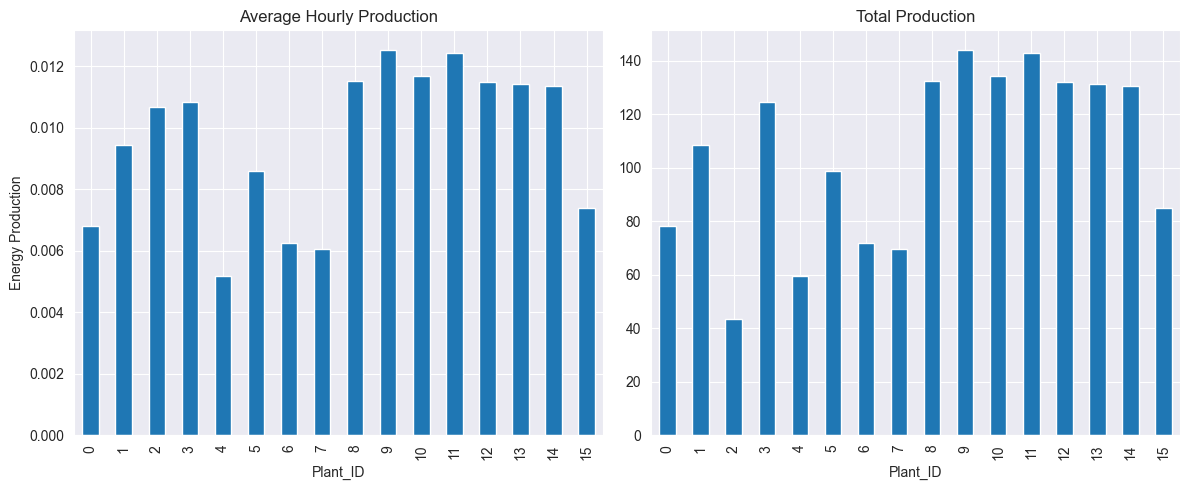

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

train_df.groupby('Plant_ID')['Energy_Production'].mean().plot(kind='bar', ax=axes[0], title="Average Hourly Production")
axes[0].set_ylabel("Energy Production")

train_df.groupby('Plant_ID')['Energy_Production'].sum().plot(kind='bar', ax=axes[1], title="Total Production")
plt.tight_layout()
plt.show()

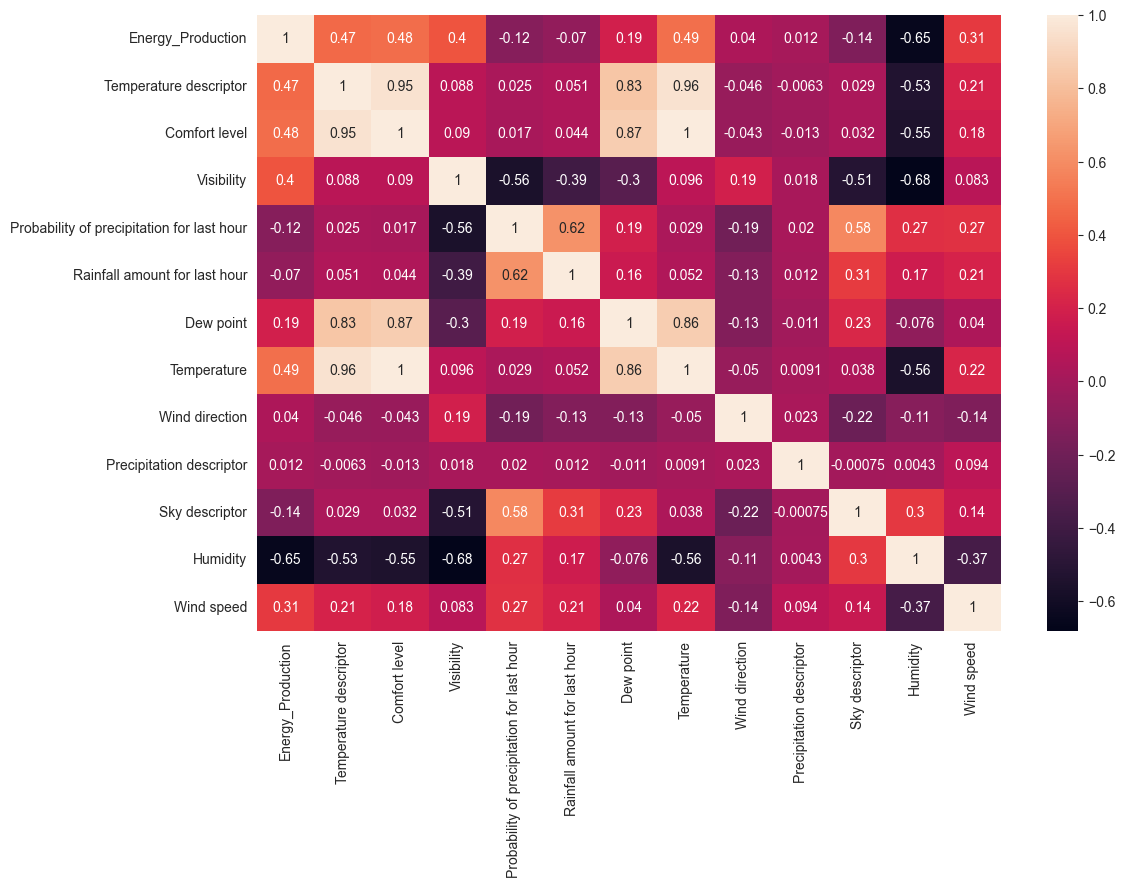

In [8]:
import seaborn as sns

corr = train_df[['Energy_Production',
       'Temperature descriptor', 'Comfort level', 'Visibility',
       'Probability of precipitation for last hour',
       'Rainfall amount for last hour', 'Dew point', 'Temperature',
       'Wind direction', 'Precipitation descriptor', 'Sky descriptor',
       'Humidity', 'Wind speed']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True)
plt.show()

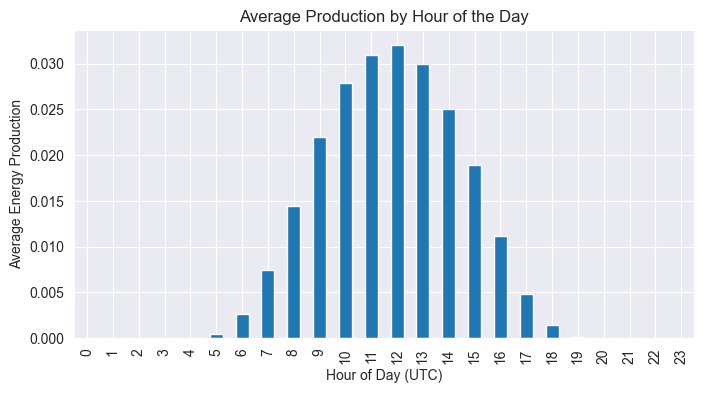

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))

train_df['UTC Time'] = pd.to_datetime(train_df['UTC Time'])
train_df['hour'] = train_df['UTC Time'].dt.hour

(
    train_df.groupby('hour')['Energy_Production']
      .mean()
      .plot(
          kind='bar',
          ax=ax,
          title="Average Production by Hour of the Day"
      )
)

ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Average Energy Production")
plt.show()

### Variance by plant

In [10]:
plant_variance = (train_df.groupby('Plant_ID')['Energy_Production'].agg(
          variance='var',
          std='std',
          mean='mean',
          count='count')
      .sort_values('variance', ascending=False))

display(plant_variance)

variance       std      mean  count
Plant_ID                                     
9         0.000366  0.019122  0.012543  11495
11        0.000353  0.018781  0.012435  11495
10        0.000319  0.017873  0.011692  11495
13        0.000316  0.017767  0.011424  11495
8         0.000313  0.017699  0.011513  11495
12        0.000305  0.017472  0.011482  11495
14        0.000298  0.017273  0.011365  11495
3         0.000286  0.016919  0.010838  11495
2         0.000247  0.015703  0.010683   4080
1         0.000220  0.014841  0.009457  11495
5         0.000180  0.013410  0.008600  11495
15        0.000126  0.011245  0.007379  11495
0         0.000126  0.011207  0.006816  11495
6         0.000092  0.009600  0.006253  11495
7         0.000087  0.009344  0.006058  11495
4         0.000068  0.008274  0.005186  11495

# Part 2 Feature Engineering

### Cyclical Feature Encoding

Some variables represent cyclical phenomena rather than linear quantities.

- Hour of day (0–23) is cyclical: hour 23 is close to hour 0.
- Wind direction (0–359°) is circular: 359° is close to 0°.

To preserve this structure, we apply sine and cosine transformations. This allows machine learning models to learn smooth periodic patterns
without artificial discontinuities.

### Panel-Safe Lag and Rolling Features

The dataset is panel data, with observations indexed by `Plant_ID` and `UTC time`. To avoid data leakage:
- All lagged and rolling features are computed **for each plant**
- Rolling statistics only use **past values** via a shift
- The data is sorted by time before feature construction

These features allow the model to capture short-term persistence and
local trends in energy production.


In [13]:
# -------------------------
# 0) Define raw train/test (FIX for NameError)
# -------------------------
train_raw = train_df.copy()
test_raw  = test_df.copy()

train_raw = train_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)
test_raw  = test_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)


# -------------------------
# 1) Feature engineering functions (FIXED)
# -------------------------
def add_time_and_cyclical_features(d):
    d = d.copy()
    d["UTC Time"] = pd.to_datetime(d["UTC Time"], errors="coerce")
    d["hour"] = d["UTC Time"].dt.hour

    d["hour_sin"] = np.sin(2 * np.pi * d["hour"] / 24)
    d["hour_cos"] = np.cos(2 * np.pi * d["hour"] / 24)

    d["wind_dir_sin"] = np.sin(np.deg2rad(d["Wind direction"]))
    d["wind_dir_cos"] = np.cos(np.deg2rad(d["Wind direction"]))
    return d


def add_panel_lags_and_rolls(d, lags=(1, 3, 6, 12, 24), windows=(3, 6, 12, 24)):
    d = d.copy()
    d = d.sort_values(["Plant_ID", "UTC Time"]).reset_index(drop=True)

    # Lags (panel-safe)
    for lag in lags:
        d[f"Energy_Production_lag_{lag}"] = (
            d.groupby("Plant_ID")["Energy_Production"].shift(lag)
        )

    # Rolling stats (panel-safe: past-only via shift(1))
    for w in windows:
        shifted = d.groupby("Plant_ID")["Energy_Production"].shift(1)
        d[f"EP_roll_mean_{w}"] = shifted.rolling(window=w, min_periods=w).mean()
        d[f"EP_roll_std_{w}"]  = shifted.rolling(window=w, min_periods=w).std()

    return d


# -------------------------
# 2) Apply functions
# -------------------------
train_feat = add_panel_lags_and_rolls(add_time_and_cyclical_features(train_raw))
test_feat  = add_panel_lags_and_rolls(add_time_and_cyclical_features(test_raw))

print("train_feat shape:", train_feat.shape)
print("test_feat shape :", test_feat.shape)


train_feat shape: (176505, 35)
test_feat shape : (59376, 35)


### PCA on Weather Features

Weather variables exhibit strong multicollinearity.We apply Principal Component Analysis (PCA) to continuous weather features only.

Steps:
- Standardize all features
- Retain components explaining 95% of total variance
- Replace original weather variables with PCA components

This reduces dimensionality while preserving most of the information, and allows us to compare model performance with and without PCA.


# Step 3 — Model Selection & Tuning

In this step we:
1. Build a leakage proof Train/Validation split (no shuffling, last 30% as validation).
2. Compare multiple model families:
   - Linear: Ridge, Lasso
   - Distance-based: KNN
   - Tree-based: Random Forest
   - Boosting: Gradient Boosting (baseline boosting)
3. Evaluate all models using:
   - RMSE (lower is better)
   - R² (higher is better)

We implement the two strategies:
- **Global Model**: one model trained on all plants using `Plant_ID` as a feature.
- **Local Models**: one model per `Plant_ID` (15 separate models), then aggregate performance.

In [14]:
# re-separating datasets
train_raw = train_df.copy()
test_raw  = test_df.copy()

# Ensure sorted for time  consistency
train_raw = train_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)
test_raw  = test_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)

### Implementing Global Models

In [15]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

TARGET_COL = "Energy_Production"
BENCH_COL  = "Benchmark"
TIME_COL   = "UTC Time"

# Feature columns: drop target, benchmark & time
drop_cols = [TARGET_COL, BENCH_COL, TIME_COL]
feature_cols_eval = [c for c in train_feat.columns if c not in drop_cols]

# X/y
X_train = train_feat[feature_cols_eval].copy()
y_train = train_feat[TARGET_COL].copy()

X_test  = test_feat[feature_cols_eval].copy()
y_test  = test_feat[TARGET_COL].copy()

# Numeric/categorical split
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

# Preprocess
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42))
])
categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_cols),
        ("cat", categorical_preprocess, categorical_cols)
    ]
)

# Models + grids (your set)
models = {
    "Ridge": Pipeline([("prep", preprocess), ("model", Ridge(random_state=42))]),
    "Lasso": Pipeline([("prep", preprocess), ("model", Lasso(random_state=42, max_iter=20000))]),
    "KNN": Pipeline([("prep", preprocess), ("model", KNeighborsRegressor())]),
    "RandomForest": Pipeline([("prep", preprocess), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))]),
    "GradBoost": Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))]),
}

param_grids = {
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0, 100.0]},
    "Lasso": {"model__alpha": [1e-4, 1e-3, 1e-2, 1e-1]},
    "KNN":   {"model__n_neighbors": [5, 15, 30], "model__weights": ["uniform", "distance"]},
    "RandomForest": {"model__n_estimators": [200], "model__max_depth": [None, 10, 20]},
    "GradBoost": {"model__n_estimators": [200], "model__learning_rate": [0.05, 0.1], "model__max_depth": [2, 3]},
}

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_train_test(fitted, Xtr, ytr, Xte, yte):
    pred_tr = np.clip(fitted.predict(Xtr), 0, None)
    pred_te = np.clip(fitted.predict(Xte), 0, None)
    return (
        rmse(ytr, pred_tr), float(r2_score(ytr, pred_tr)),
        rmse(yte, pred_te), float(r2_score(yte, pred_te)),
        pred_te
    )

# TimeSeries CV for tuning
tscv = TimeSeriesSplit(n_splits=3)

rows = []
test_predictions = {}  # store predictions for plotting later

for name, pipe in models.items():
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        scoring="neg_root_mean_squared_error",
        cv=tscv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best = grid.best_estimator_

    rmse_tr, r2_tr, rmse_te, r2_te, pred_te = eval_train_test(best, X_train, y_train, X_test, y_test)
    test_predictions[name] = pred_te

    rows.append({
        "model": name,
        "rmse_train": rmse_tr,
        "r2_train": r2_tr,
        "rmse_test": rmse_te,
        "r2_test": r2_te,
        "best_params": grid.best_params_
    })

results_all = pd.DataFrame(rows).sort_values("rmse_test").reset_index(drop=True)

# Benchmark metrics (train + test)
bench_train = np.clip(train_feat[BENCH_COL].values, 0, None)
bench_test  = np.clip(test_feat[BENCH_COL].values, 0, None)

bench_row = {
    "model": "Benchmark",
    "rmse_train": rmse(y_train, bench_train),
    "r2_train": float(r2_score(y_train, bench_train)),
    "rmse_test": rmse(y_test, bench_test),
    "r2_test": float(r2_score(y_test, bench_test)),
    "best_params": None
}

results_all = pd.concat([results_all, pd.DataFrame([bench_row])], ignore_index=True)
results_all = results_all.sort_values("rmse_test").reset_index(drop=True)

# Improvement vs benchmark on test
rmse_bench_test = bench_row["rmse_test"]
results_all["rmse_improve_vs_bench_%"] = 100 * (rmse_bench_test - results_all["rmse_test"]) / rmse_bench_test

display(results_all)

model    rmse_train  r2_train  rmse_test   r2_test  \
0  RandomForest  8.668965e-04  0.996828   0.003567  0.903834   
1     GradBoost  3.859526e-03  0.937118   0.003691  0.897032   
2           KNN  5.837723e-10  1.000000   0.003802  0.890719   
3         Lasso  4.398873e-03  0.918315   0.003943  0.882500   
4         Ridge  4.377687e-03  0.919100   0.003969  0.880947   
5     Benchmark  7.659262e-03  0.752354   0.007067  0.622516   

                                         best_params  rmse_improve_vs_bench_%  
0  {'model__max_depth': None, 'model__n_estimator...                49.526688  
1  {'model__learning_rate': 0.1, 'model__max_dept...                47.772320  
2  {'model__n_neighbors': 5, 'model__weights': 'd...                46.195055  
3                           {'model__alpha': 0.0001}                44.208300  
4                              {'model__alpha': 0.1}                43.840730  
5                                               None                 0.000000

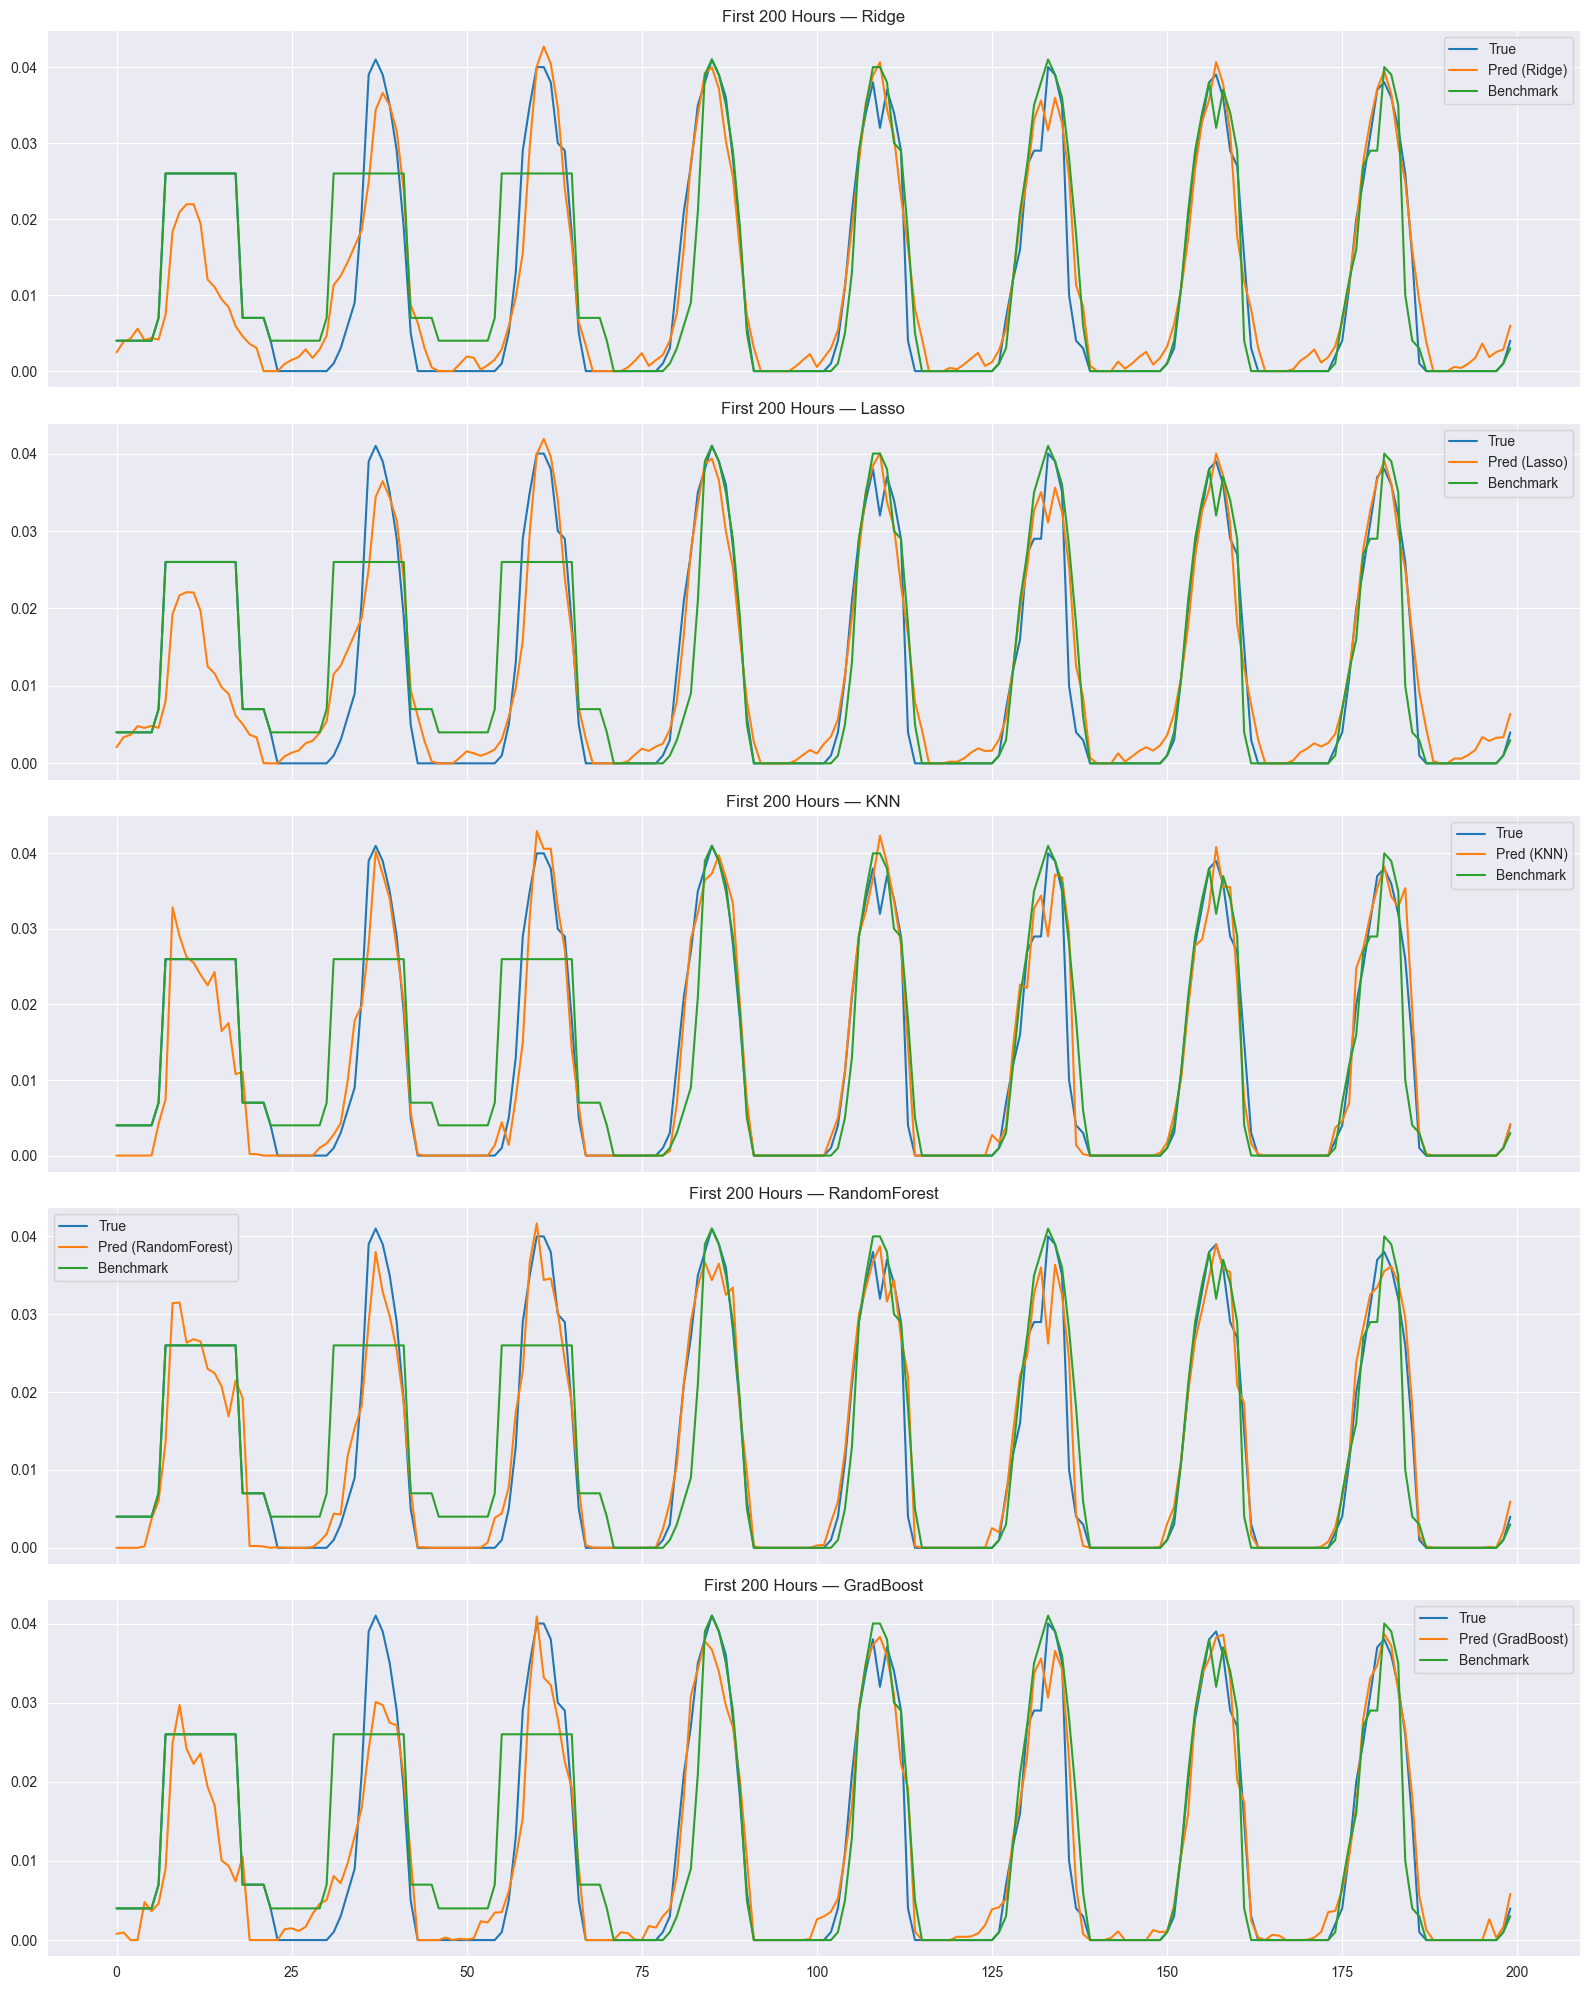

In [16]:
models_to_plot = [m for m in test_predictions.keys()]  # all ML models
n = 200
y_true = y_test.values[:n]
y_bench = np.clip(test_feat[BENCH_COL].values[:n], 0, None)

fig, axes = plt.subplots(len(models_to_plot), 1, figsize=(16, 4*len(models_to_plot)), sharex=True)

if len(models_to_plot) == 1:
    axes = [axes]

for ax, m in zip(axes, models_to_plot):
    ax.plot(y_true, label="True")
    ax.plot(test_predictions[m][:n], label=f"Pred ({m})")
    ax.plot(y_bench, label="Benchmark")
    ax.set_title(f"First {n} Hours — {m}")
    ax.legend()

plt.tight_layout()
plt.show()

### Implementing Local Models

In [17]:
### Implementing Local Models
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

PLANT_COL = "Plant_ID"

# Local features: remove Plant_ID because within plant it is constant
local_feature_cols = [c for c in feature_cols_eval if c != PLANT_COL]

# Build X/y "templates" for dtype detection (important!)
X_local_template = train_feat[local_feature_cols].copy()

# Numeric/categorical split for LOCAL feature set
local_numeric_cols = X_local_template.select_dtypes(include=[np.number]).columns.tolist()
local_categorical_cols = [c for c in X_local_template.columns if c not in local_numeric_cols]

# LOCAL preprocess (same logic, but columns aligned to local_feature_cols)
local_numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42))
])

local_categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

local_preprocess = ColumnTransformer(
    transformers=[
        ("num", local_numeric_preprocess, local_numeric_cols),
        ("cat", local_categorical_preprocess, local_categorical_cols)
    ]
)

# LOCAL models (use local_preprocess)
local_models = {
    "Ridge": Pipeline([("prep", local_preprocess), ("model", Ridge(random_state=42))]),
    "Lasso": Pipeline([("prep", local_preprocess), ("model", Lasso(random_state=42, max_iter=20000))]),
    "KNN": Pipeline([("prep", local_preprocess), ("model", KNeighborsRegressor())]),
    "RandomForest": Pipeline(
        [("prep", local_preprocess), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))]),
    "GradBoost": Pipeline([("prep", local_preprocess), ("model", GradientBoostingRegressor(random_state=42))]),
}

# Same grids as before
local_param_grids = param_grids

# Time-series CV for tuning within each plant
tscv_local = TimeSeriesSplit(n_splits=3)

local_rows = []
local_test_predictions = {}

plant_ids = sorted(train_feat[PLANT_COL].unique())

for pid in plant_ids:
    tr_p = train_feat[train_feat[PLANT_COL] == pid].sort_values("UTC Time")
    te_p = test_feat[test_feat[PLANT_COL] == pid].sort_values("UTC Time")

    if len(tr_p) < 200 or len(te_p) < 50:
        print(f"Skipping Plant {pid} (train={len(tr_p)}, test={len(te_p)})")
        continue

    X_tr = tr_p[local_feature_cols].copy()
    y_tr = tr_p[TARGET_COL].copy()

    X_te = te_p[local_feature_cols].copy()
    y_te = te_p[TARGET_COL].copy()

    for model_name, pipe in local_models.items():
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=local_param_grids[model_name],
            scoring="neg_root_mean_squared_error",
            cv=tscv_local,
            n_jobs=-1
        )
        grid.fit(X_tr, y_tr)
        best = grid.best_estimator_

        pred_tr = np.clip(best.predict(X_tr), 0, None)
        pred_te = np.clip(best.predict(X_te), 0, None)

        local_rows.append({
            "Plant_ID": pid,
            "model": f"Local-{model_name}",
            "rmse_train": rmse(y_tr, pred_tr),
            "r2_train": float(r2_score(y_tr, pred_tr)),
            "rmse_test": rmse(y_te, pred_te),
            "r2_test": float(r2_score(y_te, pred_te)),
            "best_params": grid.best_params_
        })

        local_test_predictions[(pid, model_name)] = {
            "y_true": y_te.values,
            "y_pred": pred_te,
            "utc_time": te_p["UTC Time"].values,
            "benchmark": np.clip(te_p["Benchmark"].values, 0, None) if "Benchmark" in te_p.columns else None
        }

local_results_df = pd.DataFrame(local_rows).sort_values(["Plant_ID", "rmse_test"])
display(local_results_df)


Plant_ID               model    rmse_train  r2_train  rmse_test   r2_test  \
2          0           Local-KNN  1.367863e-09  1.000000   0.002246  0.923000   
3          0  Local-RandomForest  1.059478e-03  0.991061   0.002318  0.917983   
4          0     Local-GradBoost  2.525878e-03  0.949194   0.002328  0.917251   
0          0         Local-Ridge  3.250909e-03  0.915841   0.002506  0.904145   
1          0         Local-Lasso  1.120613e-02  0.000000   0.008440 -0.087489   
..       ...                 ...           ...       ...        ...       ...   
77        15           Local-KNN  2.451286e-09  1.000000   0.002472  0.915335   
78        15  Local-RandomForest  1.016177e-03  0.991833   0.002548  0.910052   
79        15     Local-GradBoost  2.732797e-03  0.940930   0.002665  0.901602   
75        15         Local-Ridge  3.185192e-03  0.919755   0.002781  0.892887   
76        15         Local-Lasso  1.124412e-02  0.000000   0.008867 -0.089097   

                                          best_params  
2   {'model__n_neighbors': 15, 'model__weights': '...  
3   {'model__max_depth': None, 'model__n_estimator...  
4   {'model__learning_rate': 0.1, 'model__max_dept...  
0                             {'model__alpha': 100.0}  
1                               {'model__alpha': 0.1}  
..                                                ...  
77  {'model__n_neighbors': 30, 'model__weights': '...  
78  {'model__max_depth': None, 'model__n_estimator...  
79  {'model__learning_rate': 0.05, 'model__max_dep...  
75                            {'model__alpha': 100.0}  
76                              {'model__alpha': 0.1}  

[80 rows x 7 columns]

#### A) Average metrics per model family across plants

In [18]:
local_summary_by_model = (
    local_results_df
    .groupby("model")[["rmse_train", "r2_train", "rmse_test", "r2_test"]]
    .mean()
    .sort_values("rmse_test")
)

display(local_summary_by_model)

rmse_train  r2_train  rmse_test   r2_test
model                                                          
Local-KNN           2.614267e-09  1.000000   0.003414  0.898441
Local-RandomForest  1.326798e-03  0.991918   0.003416  0.898019
Local-GradBoost     3.451762e-03  0.944751   0.003608  0.887002
Local-Ridge         4.204988e-03  0.919484   0.003736  0.881194
Local-Lasso         1.409044e-02  0.057059   0.010968 -0.066915

#### B) Best local model per plant (select by lowest test RMSE)

#### C) “Local strategy overall score” (mean of best per-plant models)

In [24]:
best_local_per_plant = (
    local_results_df
    .sort_values(["Plant_ID", "rmse_test"])
    .groupby("Plant_ID", as_index=False)
    .first()
)

display(best_local_per_plant)

Plant_ID               model    rmse_train  r2_train  rmse_test   r2_test  \
0          0           Local-KNN  1.367863e-09  1.000000   0.002246  0.923000   
1          1  Local-RandomForest  1.339752e-03  0.991850   0.003036  0.898765   
2          2           Local-KNN  1.654833e-09  1.000000   0.003955  0.869374   
3          3  Local-RandomForest  1.453270e-03  0.992621   0.004175  0.889688   
4          4         Local-Ridge  2.262371e-03  0.925222   0.001708  0.859250   
5          5           Local-KNN  3.337730e-09  1.000000   0.002779  0.910624   
6          6           Local-KNN  2.175161e-09  1.000000   0.002236  0.897702   
7          7           Local-KNN  2.178409e-09  1.000000   0.001837  0.917805   
8          8  Local-RandomForest  1.565696e-03  0.992174   0.003976  0.897971   
9          9  Local-RandomForest  1.722079e-03  0.991889   0.004516  0.914739   
10        10  Local-RandomForest  1.614498e-03  0.991840   0.004676  0.888040   
11        11           Local-KNN  2.196200e-09  1.000000   0.004434  0.915383   
12        12           Local-KNN  3.654053e-09  1.000000   0.003762  0.915097   
13        13  Local-RandomForest  1.600473e-03  0.991884   0.004240  0.919193   
14        14           Local-KNN  3.724589e-09  1.000000   0.003819  0.896119   
15        15           Local-KNN  2.451286e-09  1.000000   0.002472  0.915335   

                                          best_params  
0   {'model__n_neighbors': 15, 'model__weights': '...  
1   {'model__max_depth': 20, 'model__n_estimators'...  
2   {'model__n_neighbors': 15, 'model__weights': '...  
3   {'model__max_depth': 20, 'model__n_estimators'...  
4                             {'model__alpha': 100.0}  
5   {'model__n_neighbors': 30, 'model__weights': '...  
6   {'model__n_neighbors': 30, 'model__weights': '...  
7   {'model__n_neighbors': 30, 'model__weights': '...  
8   {'model__max_depth': None, 'model__n_estimator...  
9   {'model__max_depth': None, 'model__n_estimator...  
10  {'model__max_depth': None, 'model__n_estimator...  
11  {'model__n_neighbors': 15, 'model__weights': '...  
12  {'model__n_neighbors': 30, 'model__weights': '...  
13  {'model__max_depth': None, 'model__n_estimator...  
14  {'model__n_neighbors': 30, 'model__weights': '...  
15  {'model__n_neighbors': 30, 'model__weights': '...

In [25]:
local_best_overall = best_local_per_plant[["rmse_train", "r2_train", "rmse_test", "r2_test"]].mean()
print("Local strategy (best-per-plant average):")
display(local_best_overall.to_frame("mean_metric"))

Local strategy (best-per-plant average):


mean_metric
rmse_train     0.000722
r2_train       0.992342
rmse_test      0.003367
r2_test        0.901755

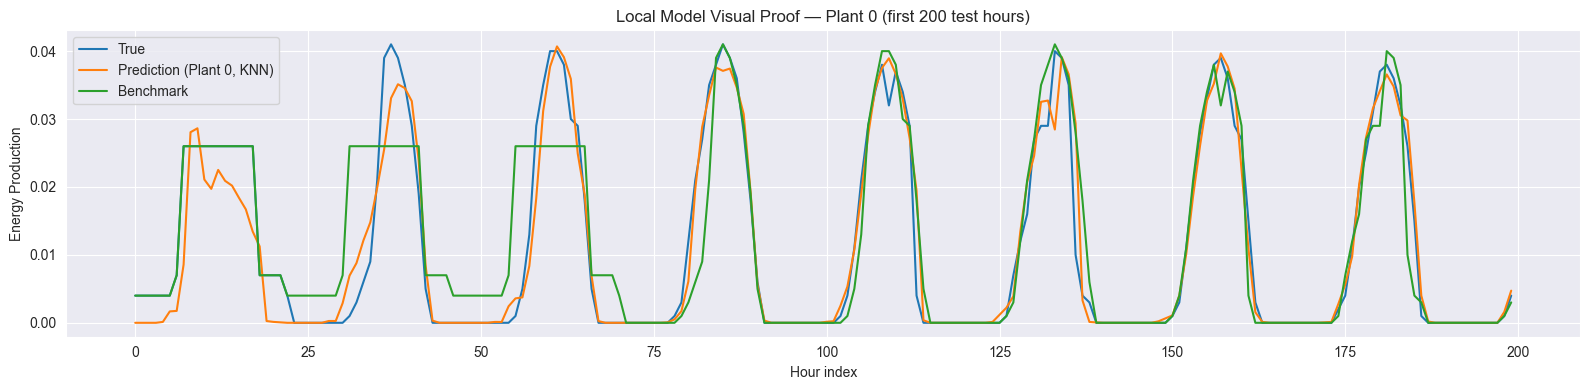

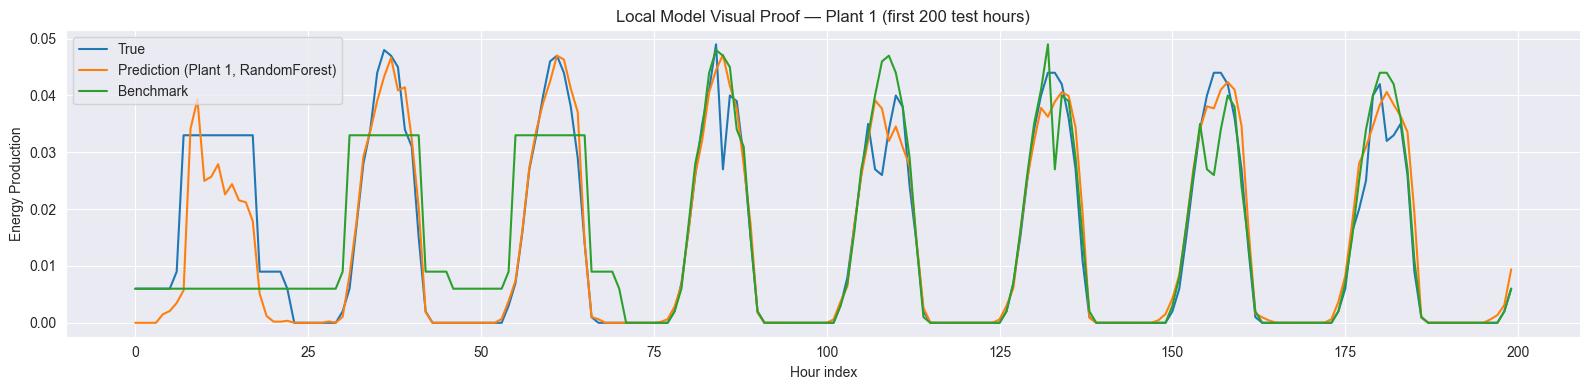

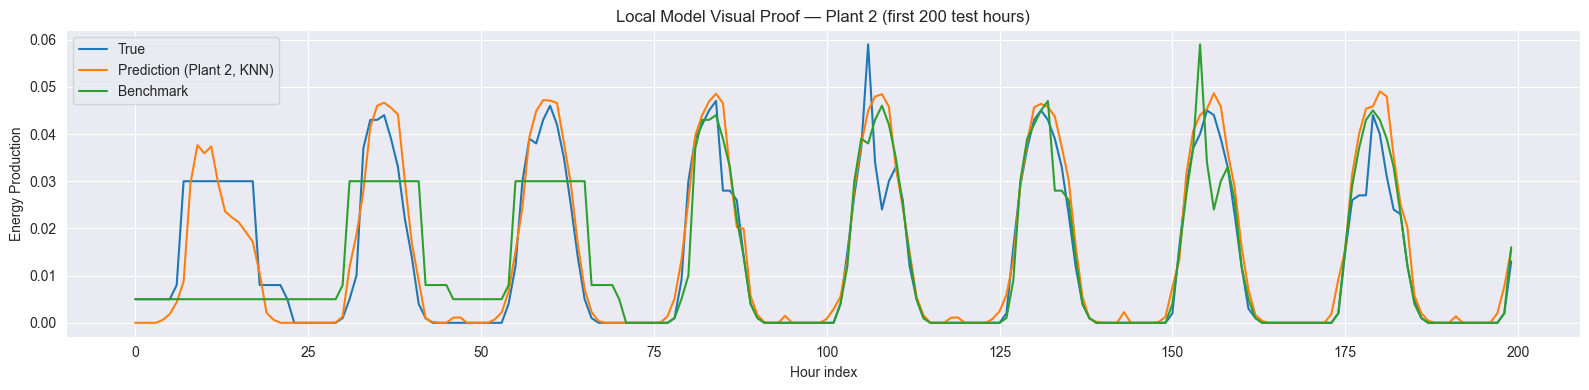

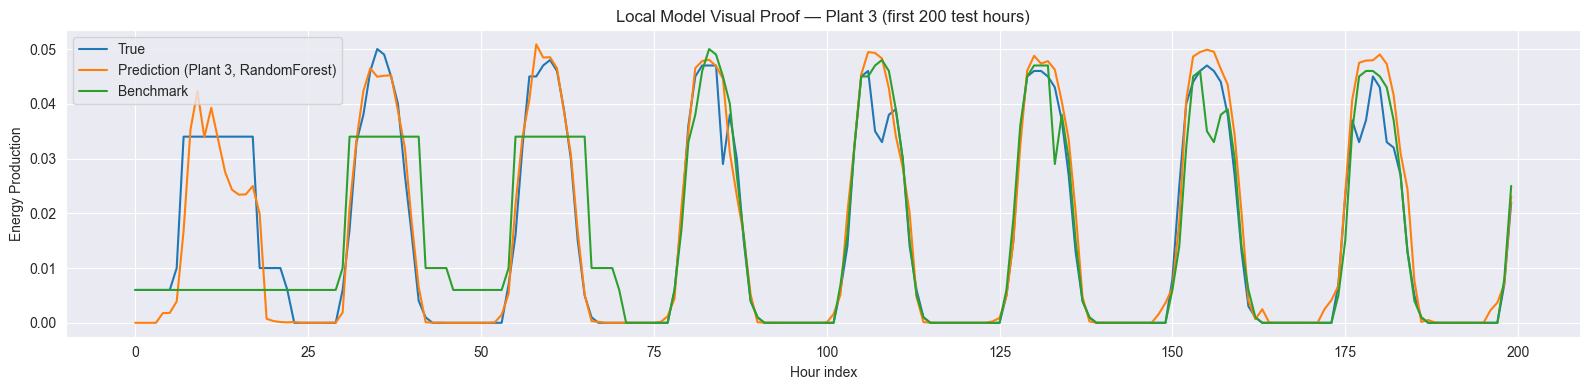

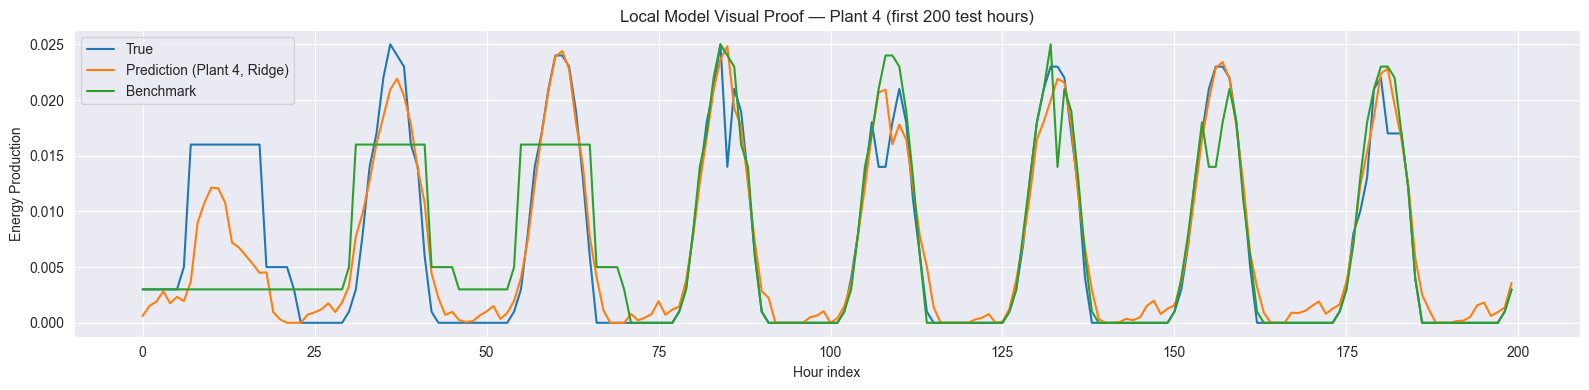

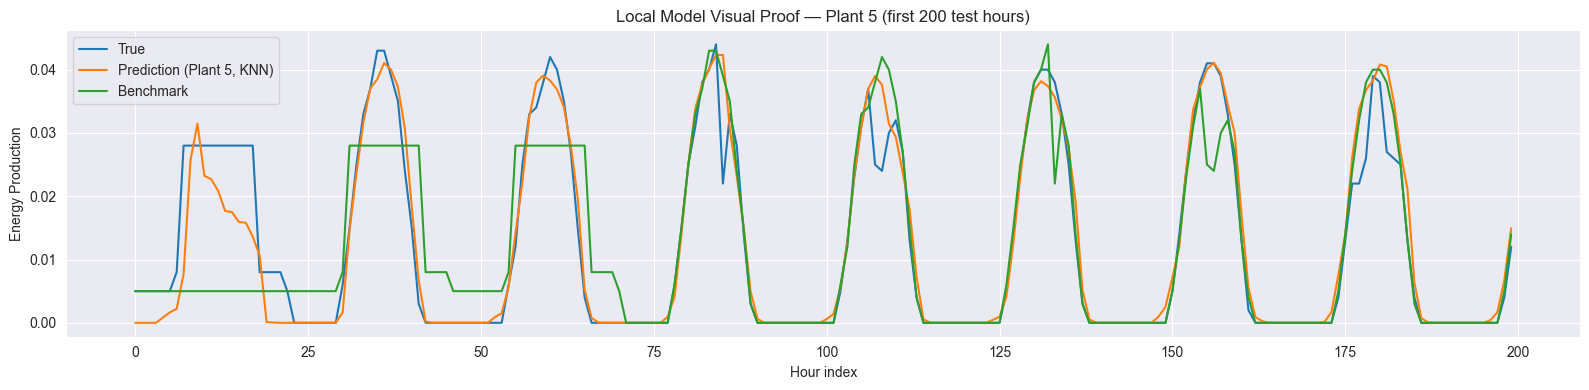

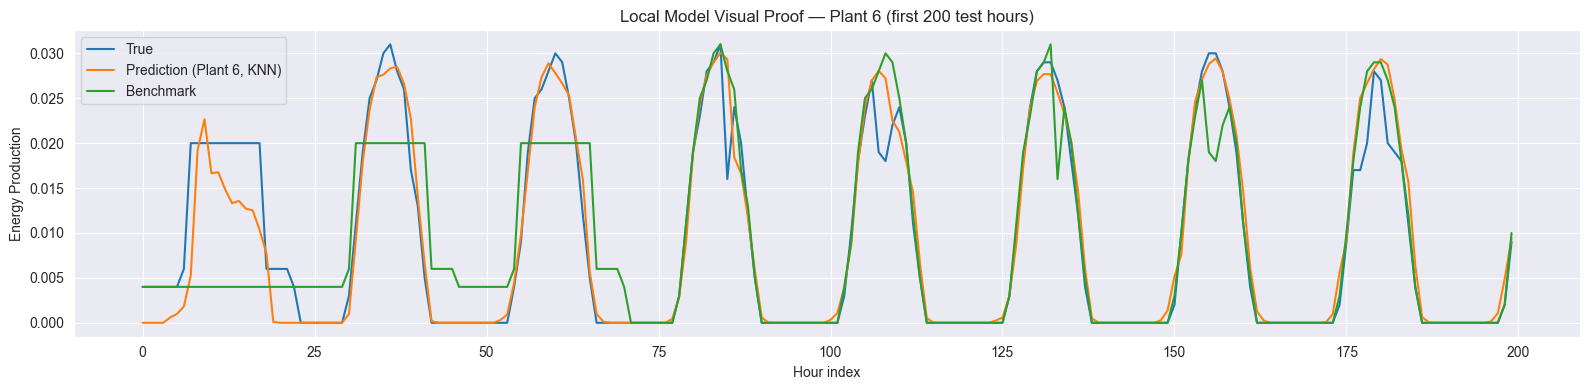

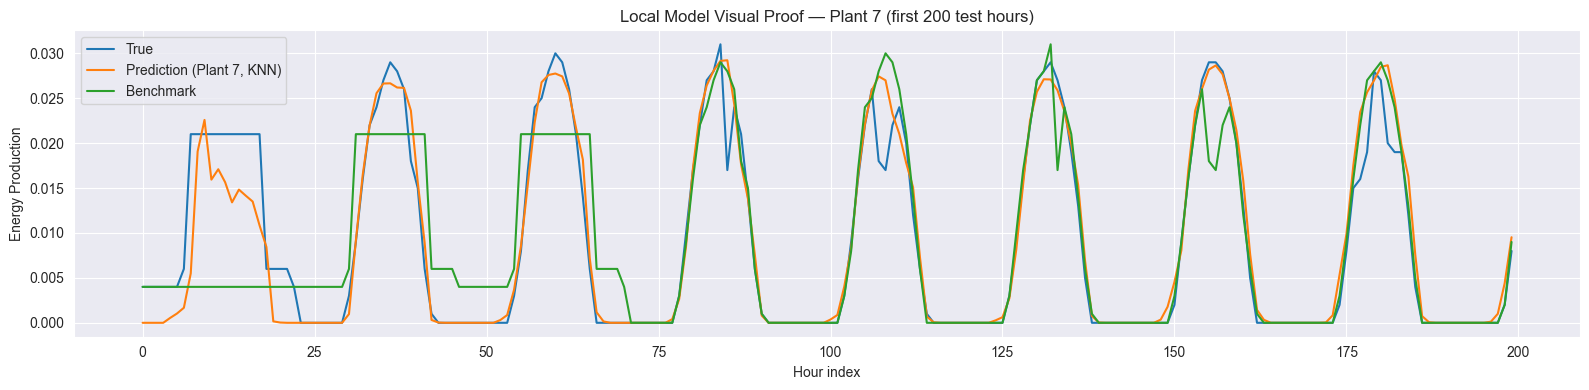

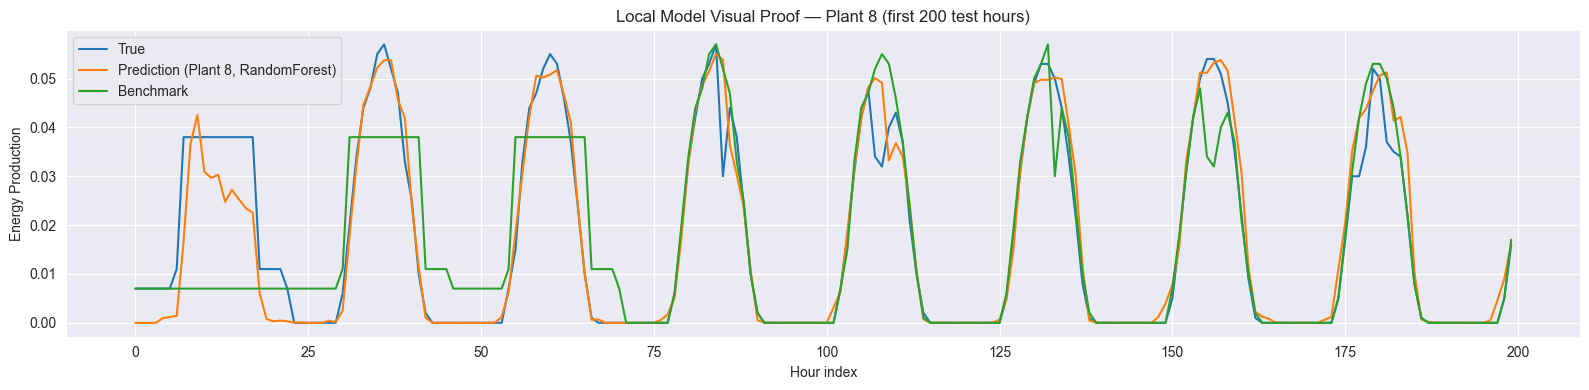

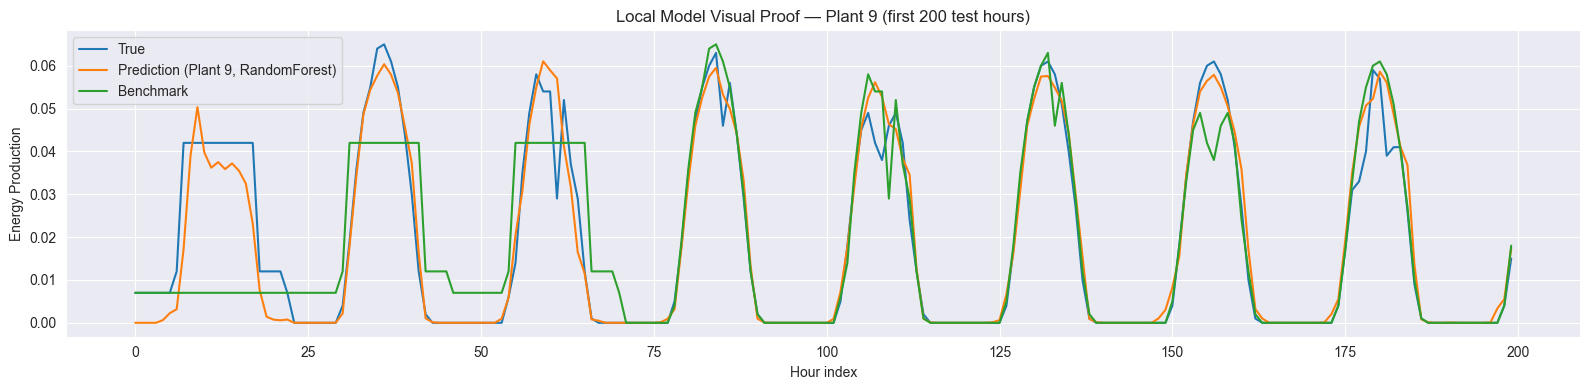

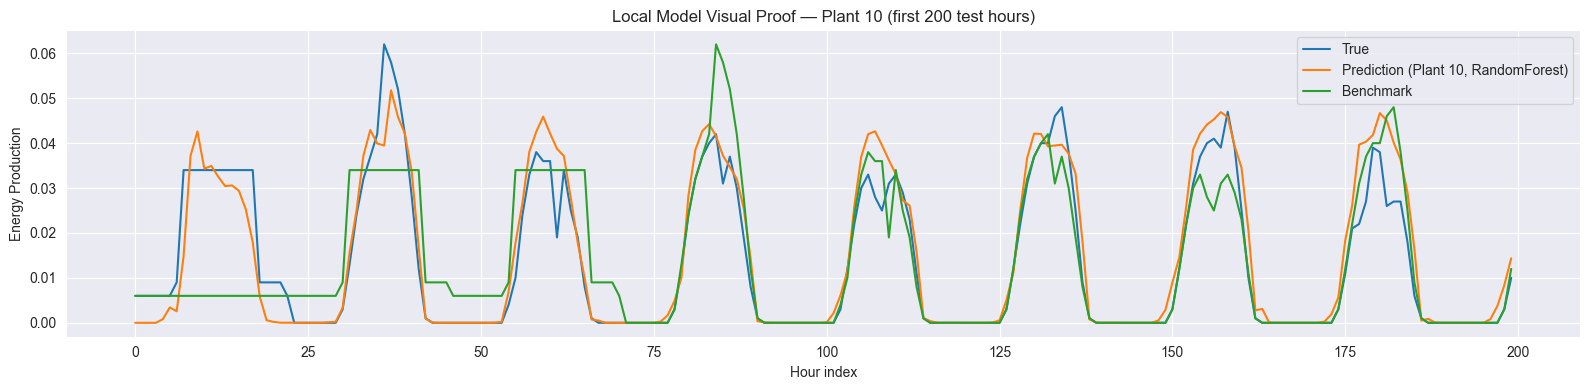

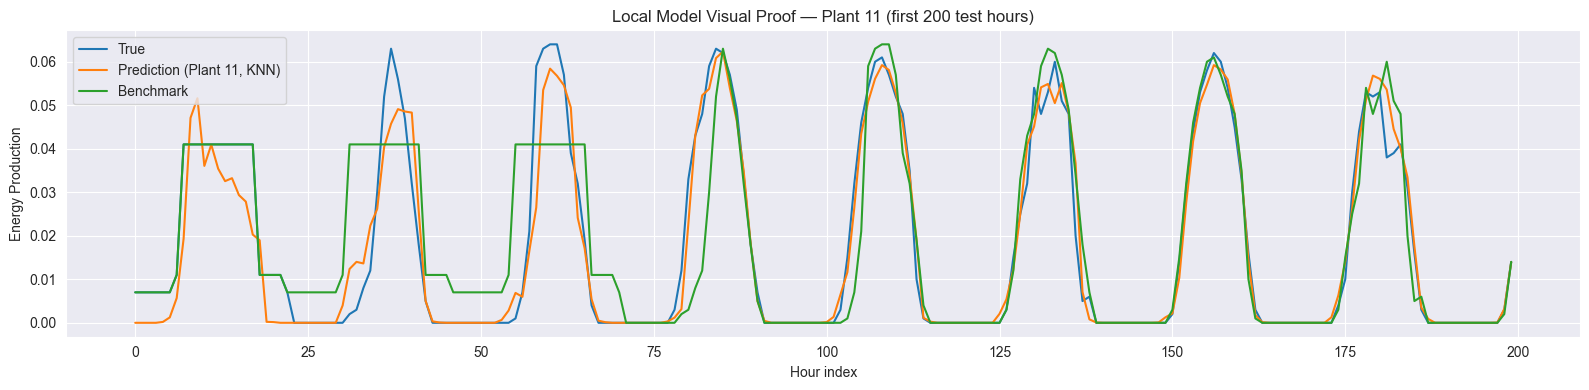

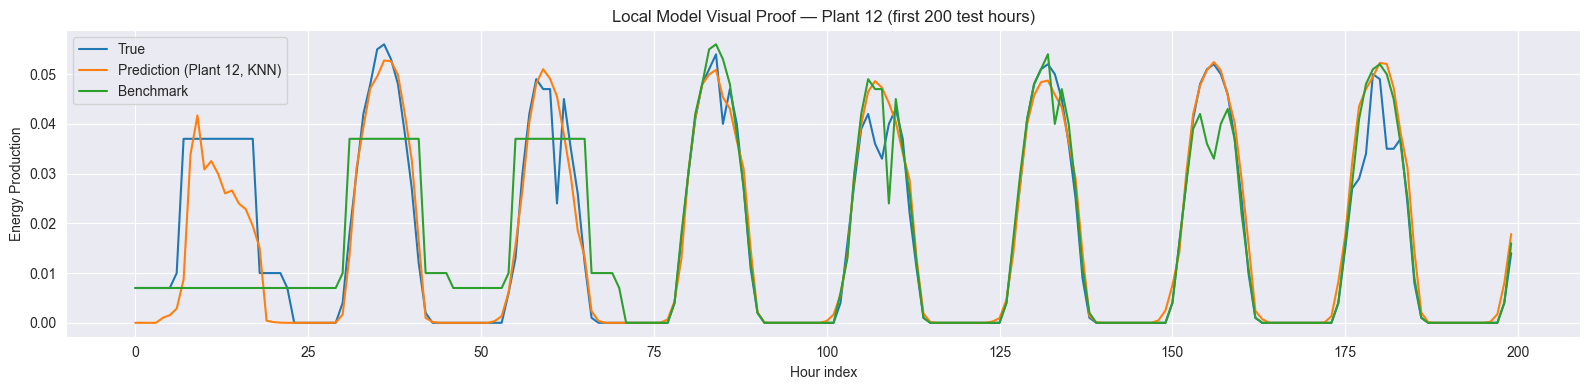

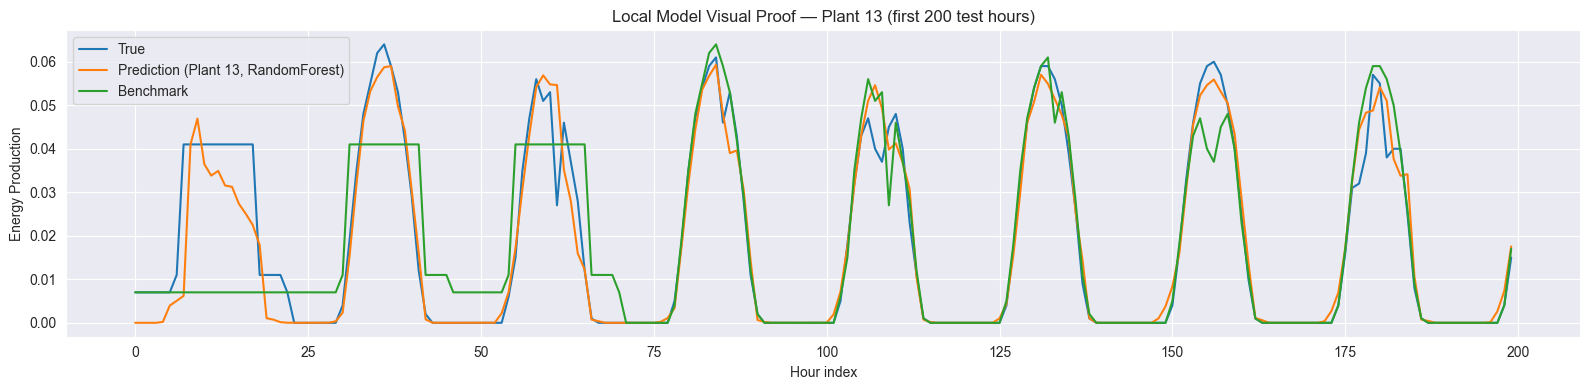

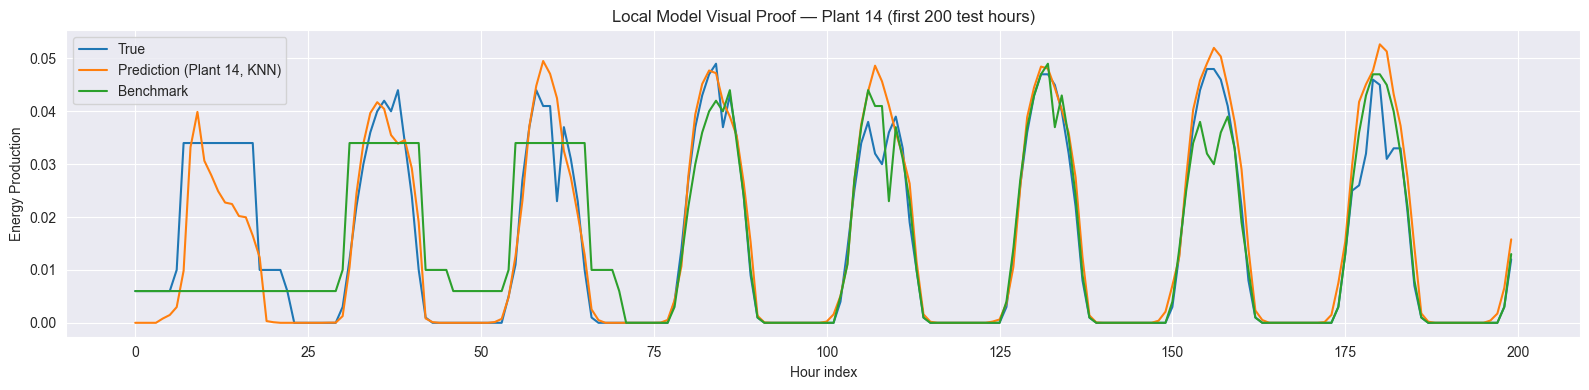

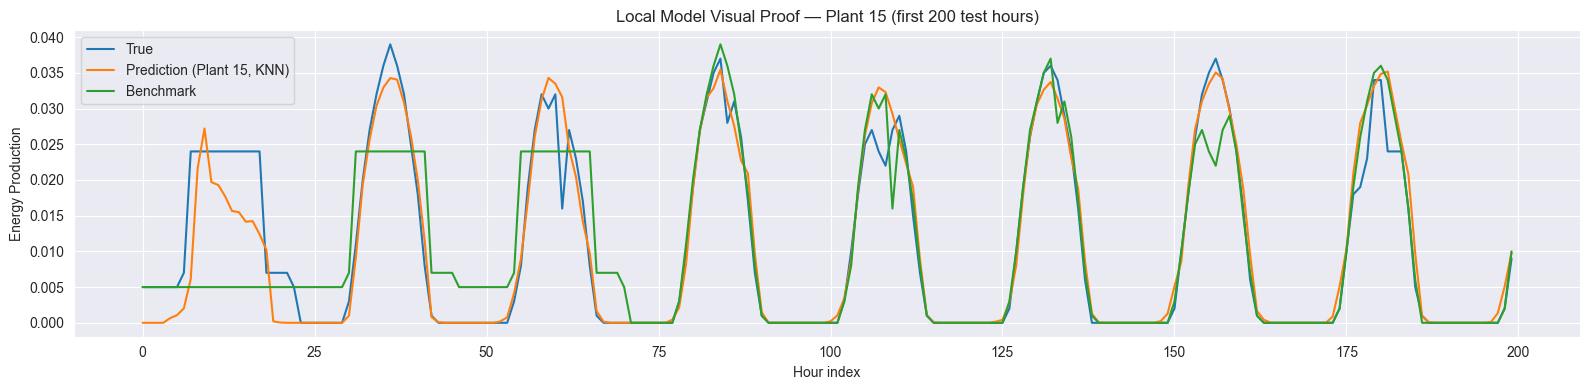

In [26]:
# Plot for EVERY plant using its best local model
n = 200  # first n test hours per plant

for pid in sorted(best_local_per_plant["Plant_ID"].unique()):
    # best model for this plant
    best_model_for_pid = best_local_per_plant.loc[
        best_local_per_plant["Plant_ID"] == pid, "model"
    ].iloc[0]
    model_name = best_model_for_pid.replace("Local-", "")

    key = (pid, model_name)
    if key not in local_test_predictions:
        print(f"Missing predictions for Plant {pid}, model {model_name}. Skipping.")
        continue

    pack = local_test_predictions[key]

    # sort by time for clean plot
    order = np.argsort(pack["utc_time"])
    y_true = pack["y_true"][order]
    y_pred = pack["y_pred"][order]
    y_bench = pack["benchmark"][order] if pack["benchmark"] is not None else None

    nn = min(n, len(y_true))

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(y_true[:nn], label="True")
    ax.plot(y_pred[:nn], label=f"Prediction (Plant {pid}, {model_name})")
    if y_bench is not None:
        ax.plot(y_bench[:nn], label="Benchmark")

    ax.set_title(f"Local Model Visual Proof — Plant {pid} (first {nn} test hours)")
    ax.set_xlabel("Hour index")
    ax.set_ylabel("Energy Production")
    ax.legend()
    plt.tight_layout()
    plt.show()


# Part 4 — Model Interpretation (XAI)

We provide both:

## Global interpretation
- **Permutation Importance**: model-agnostic feature importance measured by performance drop when a feature is shuffled.
- **SHAP (global)**: identifies the most influential drivers and shows the direction of their effect.

## Local interpretation
- **SHAP (local)**: explains a single prediction (e.g., peak production or a large-error anomaly) by decomposing the prediction into feature contributions.

Important note with PCA:
- Some drivers become **PCA components** (PC1, PC2, …). These represent combinations of the original weather variables.
- Lag/rolling features and cyclical features remain directly interpretable.


Tuning Ridge ...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=12. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning Lasso ...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=12. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning KNN ...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=12. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning RandomForest ...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=12. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning GradBoost ...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=12. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


model    rmse_train  r2_train  rmse_test   r2_test  \
0  RandomForest  8.668965e-04  0.996828   0.003567  0.903834   
1     GradBoost  3.859526e-03  0.937118   0.003691  0.897032   
2           KNN  5.837723e-10  1.000000   0.003802  0.890719   
3         Lasso  4.398873e-03  0.918315   0.003943  0.882500   
4         Ridge  4.377682e-03  0.919100   0.003969  0.880950   

                                         best_params  
0  {'model__n_estimators': 200, 'model__max_depth...  
1  {'model__n_estimators': 200, 'model__max_depth...  
2  {'model__weights': 'distance', 'model__n_neigh...  
3                           {'model__alpha': 0.0001}  
4                             {'model__alpha': 10.0}

Best GLOBAL model: RandomForest


feature  importance_mean  importance_std
1                  Day-Night         0.003369        0.000508
25             EP_roll_std_3         0.000782        0.000011
19   Energy_Production_lag_1         0.000505        0.000080
21   Energy_Production_lag_6         0.000496        0.000038
15                  hour_sin         0.000442        0.000141
27             EP_roll_std_6         0.000436        0.000084
14                      hour         0.000397        0.000028
23  Energy_Production_lag_24         0.000282        0.000103
24            EP_roll_mean_3         0.000204        0.000015
29            EP_roll_std_12         0.000162        0.000045
31            EP_roll_std_24         0.000118        0.000091
30           EP_roll_mean_24         0.000053        0.000041
11            Sky descriptor         0.000025        0.000042
26            EP_roll_mean_6        -0.000013        0.000047
28           EP_roll_mean_12        -0.000015        0.000031
4                 Visibility        -0.000021        0.000018
20   Energy_Production_lag_3        -0.000021        0.000022
22  Energy_Production_lag_12        -0.000021        0.000011
18              wind_dir_cos        -0.000031        0.000020
13                Wind speed        -0.000033        0.000015

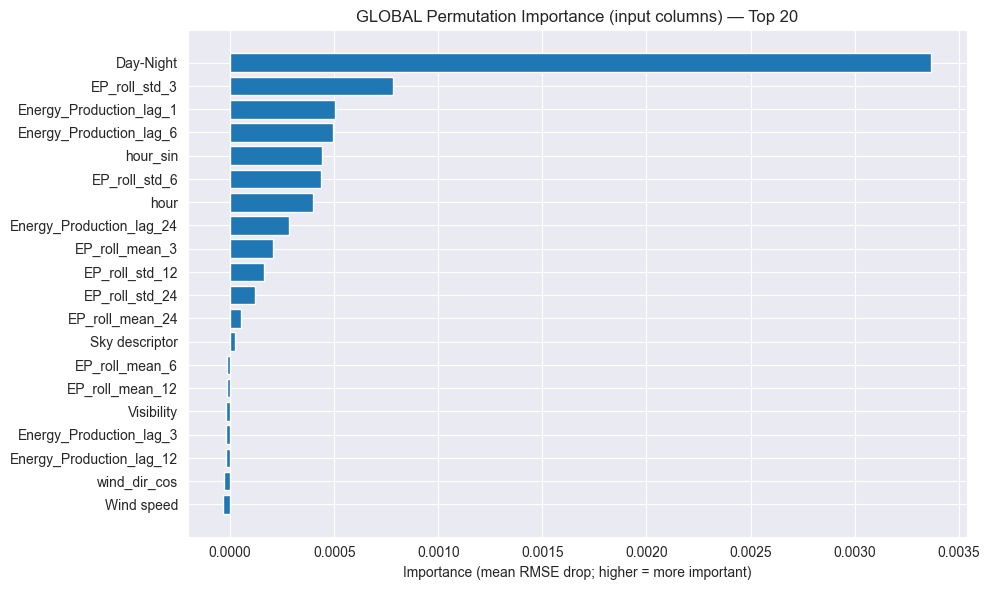

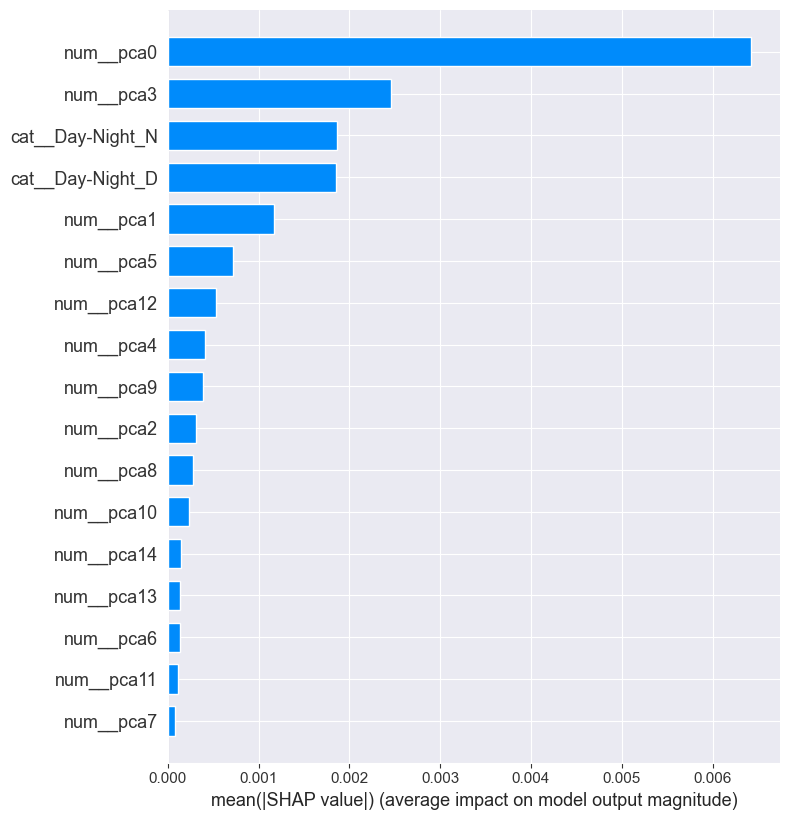

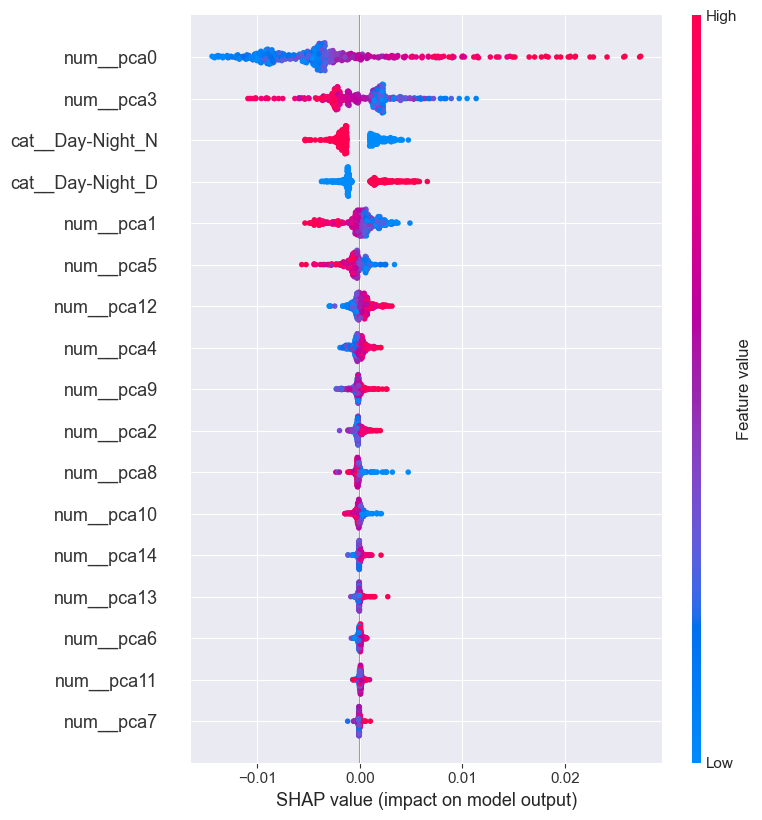

GLOBAL anomaly idx: 14648 | y_true: 0.097 | y_pred: 0.0009300000000000007 | abs_err: 0.09607


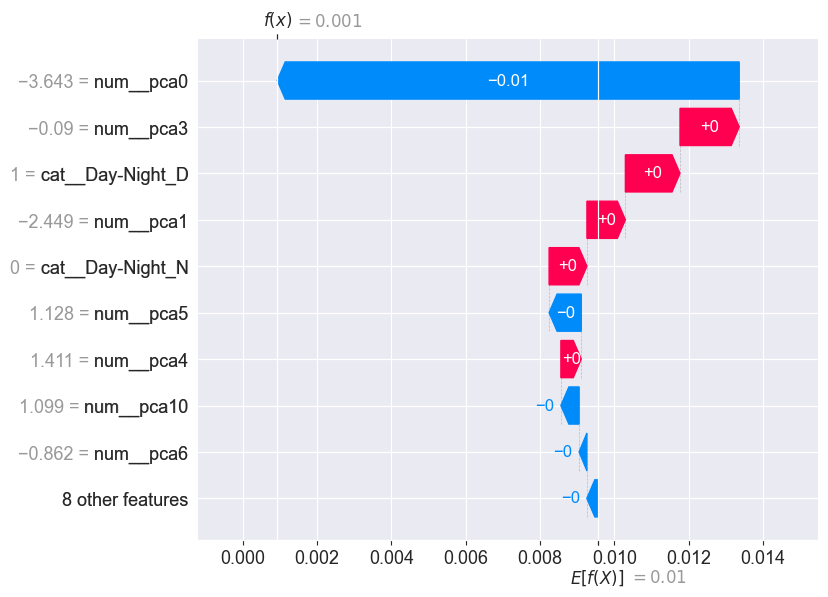

Best LOCAL model for Plant 0: KNN
Tuning LOCAL KNN for Plant 0 ...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LOCAL Plant 0] RMSE train=0.000000, test=0.002246 | R2 train=1.0000, test=0.9230
LOCAL SHAP skipped/failed: TypeError("The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsRegressor(n_neighbors=15, weights='distance')")


In [28]:
# ============================================================
# FAST + STABLE end-to-end block:
#  - caches preprocessing in CV (Pipeline(memory=...))
#  - avoids re-running GridSearch in Part 4 (reuses best estimators)
#  - safe parallelism (threads for permutation importance to avoid SIGSEGV)
#  - lighter XAI (subsampling + fewer repeats)
#  - optional: RandomizedSearchCV for faster tuning
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Memory, parallel_backend
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# -----------------------------
# EXPECTS these already exist from your notebook:
# models, param_grids
# X_train, y_train, X_test, y_test
# results_all (optional; this block can rebuild it)
#
# local_models, local_param_grids (optional, only if you want local XAI)
# local_results_df, local_feature_cols, train_feat, test_feat
# TARGET_COL, TIME_COL, PLANT_COL
# -----------------------------

# -----------------------------
# Speed/robustness knobs
# -----------------------------
CFG = {
    # TUNING
    "use_random_search": True,  # True = much faster; False = exact GridSearch
    "random_n_iter": 12,  # only used if use_random_search=True
    "tscv_splits": 2,  # 2 is faster than 3 (still time-safe)
    "tuning_n_jobs": -1,  # parallelize tuning
    "force_rf_n_jobs_1": True,  # avoid nested parallelism inside RF

    # CACHING (big win for pipelines)
    "cache_dir": "./sk_cache",  # folder for joblib cache

    # PERMUTATION IMPORTANCE (XAI)
    "pi_subsample_n": 1500,  # lower = faster
    "pi_repeats": 2,  # lower = faster
    "pi_max_samples": 0.6,  # fraction per repeat (stability + speed)
    "pi_backend": "threading",  # critical to avoid loky SIGSEGV
    "pi_n_jobs": -1,  # threads across cores

    # SHAP (XAI)
    "shap_subsample_n": 500,  # lower = faster
    "shap_bg_n": 150,  # background size for generic explainer
}

os.makedirs(CFG["cache_dir"], exist_ok=True)
memory = Memory(location=CFG["cache_dir"], verbose=0)


def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def eval_train_test(fitted, Xtr, ytr, Xte, yte):
    pred_tr = np.clip(fitted.predict(Xtr), 0, None)
    pred_te = np.clip(fitted.predict(Xte), 0, None)
    return (
        rmse(ytr, pred_tr), float(r2_score(ytr, pred_tr)),
        rmse(yte, pred_te), float(r2_score(yte, pred_te)),
        pred_tr, pred_te
    )


def safe_subsample(X, y, n=1000, seed=42):
    n = min(n, len(X))
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(X), size=n, replace=False)
    return X.iloc[idx], y.iloc[idx]


def is_tree_model(m):
    return m.__class__.__name__ in ["RandomForestRegressor", "GradientBoostingRegressor"]


# -----------------------------
# 1) FAST tuning + metrics table + store best estimators (GLOBAL)
# -----------------------------
tscv = TimeSeriesSplit(n_splits=CFG["tscv_splits"])
best_estimators_global = {}
test_predictions_global = {}

rows = []
for name, pipe in models.items():
    # cache preprocessing during CV
    pipe_cached = Pipeline(pipe.steps, memory=memory)

    # avoid nested parallelism (RF inside CV + outer n_jobs)
    if CFG["force_rf_n_jobs_1"]:
        try:
            if pipe_cached.named_steps["model"].__class__.__name__ == "RandomForestRegressor":
                pipe_cached.named_steps["model"].set_params(n_jobs=1)
        except Exception:
            pass

    if CFG["use_random_search"]:
        search = RandomizedSearchCV(
            estimator=pipe_cached,
            param_distributions=param_grids[name],
            n_iter=CFG["random_n_iter"],
            scoring="neg_root_mean_squared_error",
            cv=tscv,
            n_jobs=CFG["tuning_n_jobs"],
            random_state=42,
            error_score="raise",
        )
    else:
        search = GridSearchCV(
            estimator=pipe_cached,
            param_grid=param_grids[name],
            scoring="neg_root_mean_squared_error",
            cv=tscv,
            n_jobs=CFG["tuning_n_jobs"],
            error_score="raise",
        )

    print(f"Tuning {name} ...")
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_estimators_global[name] = best

    rmse_tr, r2_tr, rmse_te, r2_te, pred_tr, pred_te = eval_train_test(best, X_train, y_train, X_test, y_test)
    test_predictions_global[name] = pred_te

    rows.append({
        "model": name,
        "rmse_train": rmse_tr,
        "r2_train": r2_tr,
        "rmse_test": rmse_te,
        "r2_test": r2_te,
        "best_params": search.best_params_
    })

results_all_fast = pd.DataFrame(rows).sort_values("rmse_test").reset_index(drop=True)
display(results_all_fast)

best_global_name = results_all_fast.iloc[0]["model"]
best_global_pipe = best_estimators_global[best_global_name]
print("Best GLOBAL model:", best_global_name)

# -----------------------------
# 2) Permutation importance (FAST + stable; correct feature names)
# -----------------------------
from sklearn.base import clone

X_pi, y_pi = safe_subsample(X_test, y_test, n=CFG["pi_subsample_n"], seed=42)

# (optional) clone to ensure clean state
best_global_pipe_for_pi = best_global_pipe

with parallel_backend(CFG["pi_backend"]):
    perm = permutation_importance(
        best_global_pipe_for_pi,
        X_pi,
        y_pi,
        scoring="neg_root_mean_squared_error",
        n_repeats=CFG["pi_repeats"],
        random_state=42,
        n_jobs=CFG["pi_n_jobs"],
        max_samples=CFG["pi_max_samples"],
    )

# IMPORTANT: permutation importance is defined over INPUT columns
imp_df = pd.DataFrame({
    "feature": np.array(X_pi.columns, dtype=str),
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp_df.head(20))

top_k = 20
plot_df = imp_df.head(top_k).iloc[::-1]
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(plot_df["feature"], plot_df["importance_mean"])
ax.set_title(f"GLOBAL Permutation Importance (input columns) — Top {top_k}")
ax.set_xlabel("Importance (mean RMSE drop; higher = more important)")
plt.tight_layout()
plt.show()

# -----------------------------
# 3) SHAP (FAST) — summary + local anomaly waterfall
# -----------------------------
try:
    import shap

    prep_g = best_global_pipe.named_steps["prep"]
    model_g = best_global_pipe.named_steps["model"]

    X_shap, y_shap = safe_subsample(X_test, y_test, n=CFG["shap_subsample_n"], seed=7)
    X_shap_trans = prep_g.transform(X_shap)

    try:
        feat_names_trans_g = prep_g.get_feature_names_out()
    except Exception:
        feat_names_trans_g = [f"f{i}" for i in range(X_shap_trans.shape[1])]

    # Explainer choice
    if is_tree_model(model_g):
        expl_g = shap.TreeExplainer(model_g)
        sv_g = expl_g.shap_values(X_shap_trans)
        shap.summary_plot(sv_g, X_shap_trans, feature_names=feat_names_trans_g, plot_type="bar", max_display=20)
        shap.summary_plot(sv_g, X_shap_trans, feature_names=feat_names_trans_g, max_display=20)
    else:
        bg = X_shap_trans[:CFG["shap_bg_n"]]
        expl_g = shap.Explainer(model_g, bg)
        sv_g = expl_g(X_shap_trans)
        shap.summary_plot(sv_g, feature_names=feat_names_trans_g, plot_type="bar", max_display=20)
        shap.summary_plot(sv_g, feature_names=feat_names_trans_g, max_display=20)

    # Local explanation for biggest error (full test)
    y_pred_g = np.clip(best_global_pipe.predict(X_test), 0, None)
    abs_err_g = np.abs(y_test.values - y_pred_g)
    idx_anom_g = int(np.argmax(abs_err_g))

    print("GLOBAL anomaly idx:", idx_anom_g,
          "| y_true:", float(y_test.values[idx_anom_g]),
          "| y_pred:", float(y_pred_g[idx_anom_g]),
          "| abs_err:", float(abs_err_g[idx_anom_g]))

    x_row = X_test.iloc[[idx_anom_g]]
    x_row_trans = prep_g.transform(x_row)

    try:
        if is_tree_model(model_g):
            sv_row = expl_g.shap_values(x_row_trans)
            base_val = expl_g.expected_value
            exp = shap.Explanation(
                values=sv_row[0] if isinstance(sv_row, list) else sv_row[0],
                base_values=base_val if np.isscalar(base_val) else base_val[0],
                data=x_row_trans[0],
                feature_names=feat_names_trans_g
            )
            shap.plots.waterfall(exp)
        else:
            exp = expl_g(x_row_trans)
            shap.plots.waterfall(exp[0])
    except Exception as e:
        print("GLOBAL local SHAP failed:", repr(e))

except Exception as e:
    print("SHAP skipped (not installed or failed):", repr(e))

# -----------------------------
# 4) LOCAL XAI (FAST): refit ONLY the best local model for ONE plant
# -----------------------------
do_local = all(k in globals() for k in [
    "local_results_df", "local_models", "local_param_grids",
    "local_feature_cols", "train_feat", "test_feat",
    "TARGET_COL", "TIME_COL", "PLANT_COL"
])

if do_local:
    # Choose plant here
    pid = 0

    # Best local-per-plant from existing local_results_df (no re-search across all plants/models)
    best_local_per_plant = (
        local_results_df
        .sort_values([PLANT_COL, "rmse_test"])
        .groupby(PLANT_COL, as_index=False)
        .first()
    )
    best_local_label = best_local_per_plant.loc[best_local_per_plant[PLANT_COL] == pid, "model"].iloc[0]
    best_local_name = best_local_label.replace("Local-", "")
    print(f"Best LOCAL model for Plant {pid}:", best_local_name)

    # Plant-specific data
    tr_p = train_feat[train_feat[PLANT_COL] == pid].sort_values(TIME_COL)
    te_p = test_feat[test_feat[PLANT_COL] == pid].sort_values(TIME_COL)

    X_tr_local = tr_p[local_feature_cols].copy()
    y_tr_local = tr_p[TARGET_COL].copy()
    X_te_local = te_p[local_feature_cols].copy()
    y_te_local = te_p[TARGET_COL].copy()

    # Refit ONLY that best local model (fast search)
    local_tscv = TimeSeriesSplit(n_splits=CFG["tscv_splits"])

    pipe_local = local_models[best_local_name]
    pipe_local_cached = Pipeline(pipe_local.steps, memory=memory)

    if CFG["force_rf_n_jobs_1"]:
        try:
            if pipe_local_cached.named_steps["model"].__class__.__name__ == "RandomForestRegressor":
                pipe_local_cached.named_steps["model"].set_params(n_jobs=1)
        except Exception:
            pass

    if CFG["use_random_search"]:
        search_l = RandomizedSearchCV(
            estimator=pipe_local_cached,
            param_distributions=local_param_grids[best_local_name],
            n_iter=min(CFG["random_n_iter"], 10),
            scoring="neg_root_mean_squared_error",
            cv=local_tscv,
            n_jobs=CFG["tuning_n_jobs"],
            random_state=42,
            error_score="raise",
        )
    else:
        search_l = GridSearchCV(
            estimator=pipe_local_cached,
            param_grid=local_param_grids[best_local_name],
            scoring="neg_root_mean_squared_error",
            cv=local_tscv,
            n_jobs=CFG["tuning_n_jobs"],
            error_score="raise",
        )

    print(f"Tuning LOCAL {best_local_name} for Plant {pid} ...")
    search_l.fit(X_tr_local, y_tr_local)
    best_local_pipe = search_l.best_estimator_

    rmse_tr, r2_tr, rmse_te, r2_te, pred_tr, pred_te = eval_train_test(best_local_pipe, X_tr_local, y_tr_local,
                                                                       X_te_local, y_te_local)
    print(f"[LOCAL Plant {pid}] RMSE train={rmse_tr:.6f}, test={rmse_te:.6f} | R2 train={r2_tr:.4f}, test={r2_te:.4f}")

    # Optional: local SHAP (fast)
    try:
        import shap

        prep_l = best_local_pipe.named_steps["prep"]
        model_l = best_local_pipe.named_steps["model"]

        X_l_shap, y_l_shap = safe_subsample(X_te_local, y_te_local, n=min(CFG["shap_subsample_n"], 400), seed=11)
        X_l_trans = prep_l.transform(X_l_shap)

        try:
            feat_names_trans_l = prep_l.get_feature_names_out()
        except Exception:
            feat_names_trans_l = [f"f{i}" for i in range(X_l_trans.shape[1])]

        if is_tree_model(model_l):
            expl_l = shap.TreeExplainer(model_l)
            sv_l = expl_l.shap_values(X_l_trans)
            shap.summary_plot(sv_l, X_l_trans, feature_names=feat_names_trans_l, plot_type="bar", max_display=20)
            shap.summary_plot(sv_l, X_l_trans, feature_names=feat_names_trans_l, max_display=20)
        else:
            bg_l = X_l_trans[:min(CFG["shap_bg_n"], len(X_l_trans))]
            expl_l = shap.Explainer(model_l, bg_l)
            sv_l = expl_l(X_l_trans)
            shap.summary_plot(sv_l, feature_names=feat_names_trans_l, plot_type="bar", max_display=20)
            shap.summary_plot(sv_l, feature_names=feat_names_trans_l, max_display=20)

        # local anomaly
        y_pred_l = np.clip(best_local_pipe.predict(X_te_local), 0, None)
        abs_err_l = np.abs(y_te_local.values - y_pred_l)
        idx_anom_l = int(np.argmax(abs_err_l))

        print(f"LOCAL anomaly idx (Plant {pid}):", idx_anom_l,
              "| y_true:", float(y_te_local.values[idx_anom_l]),
              "| y_pred:", float(y_pred_l[idx_anom_l]),
              "| abs_err:", float(abs_err_l[idx_anom_l]))

        x_row_l = X_te_local.iloc[[idx_anom_l]]
        x_row_l_trans = prep_l.transform(x_row_l)

        if is_tree_model(model_l):
            sv_row_l = expl_l.shap_values(x_row_l_trans)
            base_val_l = expl_l.expected_value
            exp_l = shap.Explanation(
                values=sv_row_l[0] if isinstance(sv_row_l, list) else sv_row_l[0],
                base_values=base_val_l if np.isscalar(base_val_l) else base_val_l[0],
                data=x_row_l_trans[0],
                feature_names=feat_names_trans_l
            )
            shap.plots.waterfall(exp_l)
        else:
            exp_l = expl_l(x_row_l_trans)
            shap.plots.waterfall(exp_l[0])

    except Exception as e:
        print("LOCAL SHAP skipped/failed:", repr(e))

else:
    print("LOCAL XAI skipped (local_* variables not found).")

Permutation Importance

feature  importance_mean  importance_std
1                  Day-Night         0.002877        0.000279
25             EP_roll_std_3         0.000711        0.000158
19   Energy_Production_lag_1         0.000522        0.000017
21   Energy_Production_lag_6         0.000521        0.000038
15                  hour_sin         0.000521        0.000079
14                      hour         0.000492        0.000050
27             EP_roll_std_6         0.000405        0.000091
23  Energy_Production_lag_24         0.000376        0.000046
24            EP_roll_mean_3         0.000274        0.000039
29            EP_roll_std_12         0.000215        0.000042
31            EP_roll_std_24         0.000113        0.000082
16                  hour_cos         0.000096        0.000059
28           EP_roll_mean_12         0.000093        0.000033
30           EP_roll_mean_24         0.000088        0.000060
18              wind_dir_cos         0.000083        0.000023
26            EP_roll_mean_6         0.000069        0.000024
22  Energy_Production_lag_12         0.000062        0.000032
11            Sky descriptor         0.000051        0.000104
20   Energy_Production_lag_3         0.000045        0.000035
4                 Visibility         0.000032        0.000052

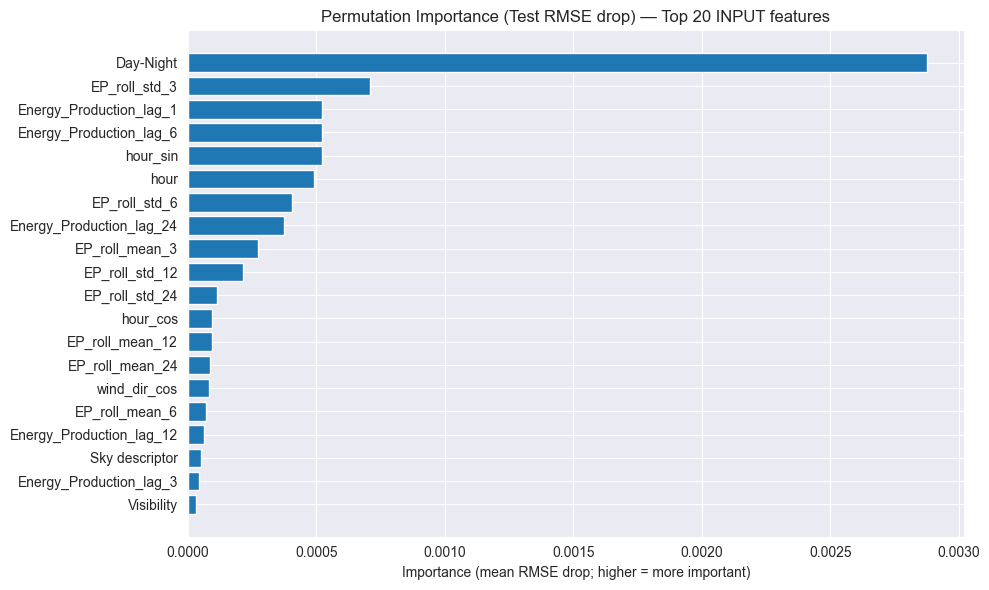

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import parallel_backend
from sklearn.inspection import permutation_importance

# ---------- helpers ----------
def safe_subsample(X, y, n=1500, seed=42):
    n = min(n, len(X))
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(X), size=n, replace=False)
    return X.iloc[idx], y.iloc[idx]

# ---------- assumes ----------
# best_global_pipe: fitted pipeline (prep + model)
# X_test, y_test: global test set

# Subsample for speed/stability
X_pi, y_pi = safe_subsample(X_test, y_test, n=1500, seed=42)

# Use threading backend to avoid loky SIGSEGV; fewer repeats to keep it fast
with parallel_backend("threading"):
    perm = permutation_importance(
        best_global_pipe,
        X_pi,
        y_pi,
        scoring="neg_root_mean_squared_error",
        n_repeats=3,
        random_state=42,
        n_jobs=-1,          # threads
        max_samples=0.7     # each repeat uses 70% of X_pi
    )

# IMPORTANT: permutation importance is over INPUT columns (X_pi.columns)
imp_df = pd.DataFrame({
    "feature": X_pi.columns.astype(str).to_numpy(),
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp_df.head(20))

# Plot top 20
top_k = 20
plot_df = imp_df.head(top_k).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(plot_df["feature"], plot_df["importance_mean"])
ax.set_title(f"Permutation Importance (Test RMSE drop) — Top {top_k} INPUT features")
ax.set_xlabel("Importance (mean RMSE drop; higher = more important)")
plt.tight_layout()
plt.show()


4B) Global — SHAP

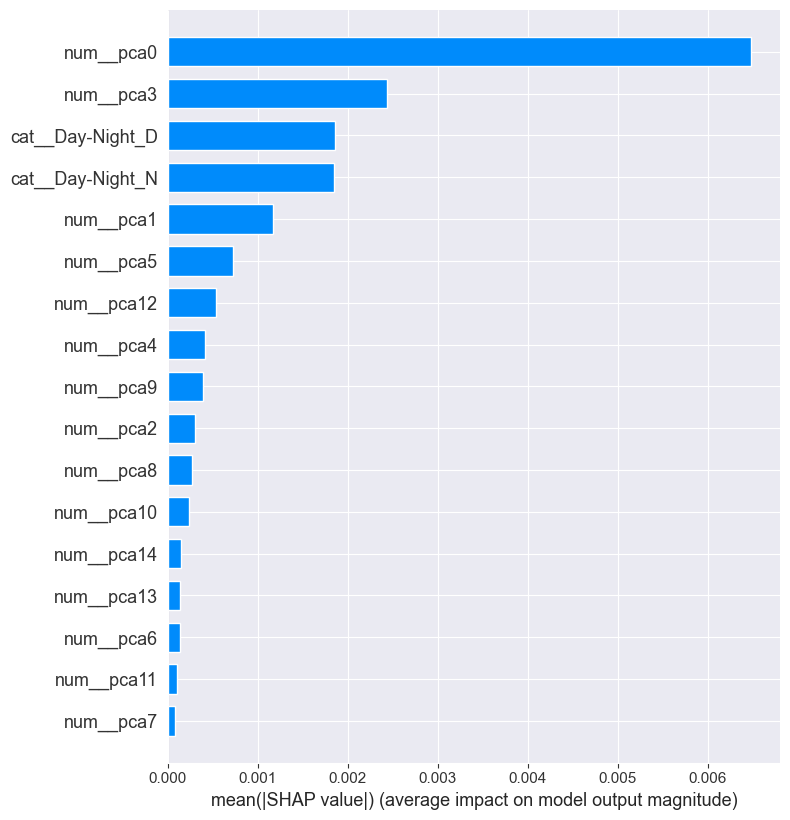

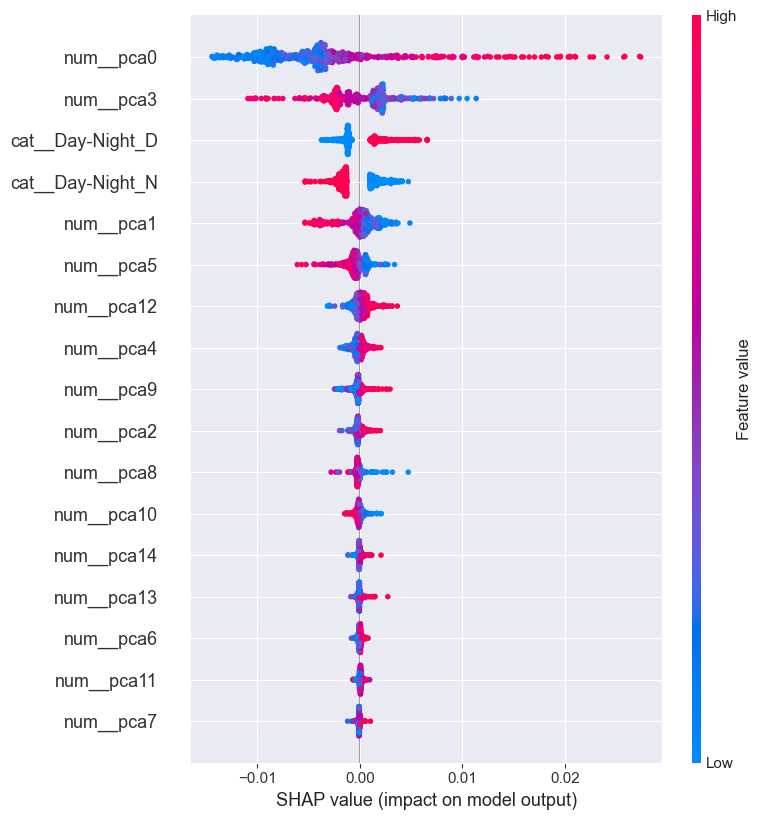

In [30]:
# SHAP (global): works on TRANSFORMED features (OneHot + PCA output)
# If shap is not installed: pip install shap
import numpy as np
from joblib import parallel_backend

import shap

# ---------- helpers ----------
def safe_subsample(X, n=600, seed=7):
    n = min(n, len(X))
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(X), size=n, replace=False)
    return X[idx]

# ---------- assumes ----------
# best_global_pipe, X_test
prep = best_global_pipe.named_steps["prep"]
model = best_global_pipe.named_steps["model"]

# Transform only a subsample for speed
X_test_trans_full = prep.transform(X_test)
idx = safe_subsample(np.arange(X_test_trans_full.shape[0]), n=600, seed=7)
X_test_trans = X_test_trans_full[idx]

# Names AFTER preprocessing (this is where PCA components show up)
try:
    feat_names_trans = prep.get_feature_names_out()
except Exception:
    feat_names_trans = [f"f{i}" for i in range(X_test_trans.shape[1])]

# Choose explainer
is_tree = model.__class__.__name__ in ["RandomForestRegressor", "GradientBoostingRegressor"]

if is_tree:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_trans)

    shap.summary_plot(shap_values, X_test_trans, feature_names=feat_names_trans,
                      plot_type="bar", max_display=20)
    shap.summary_plot(shap_values, X_test_trans, feature_names=feat_names_trans,
                      max_display=20)
else:
    # Generic explainer is slower; keep a small background
    bg = X_test_trans[:150]
    explainer = shap.Explainer(model, bg)
    shap_values = explainer(X_test_trans)

    shap.summary_plot(shap_values, feature_names=feat_names_trans,
                      plot_type="bar", max_display=20)
    shap.summary_plot(shap_values, feature_names=feat_names_trans,
                      max_display=20)


4C) Global — Local SHAP on biggest error

Anom index: 14648 | y_true: 0.097 | y_pred: 0.0009300000000000007 | abs_err: 0.09607


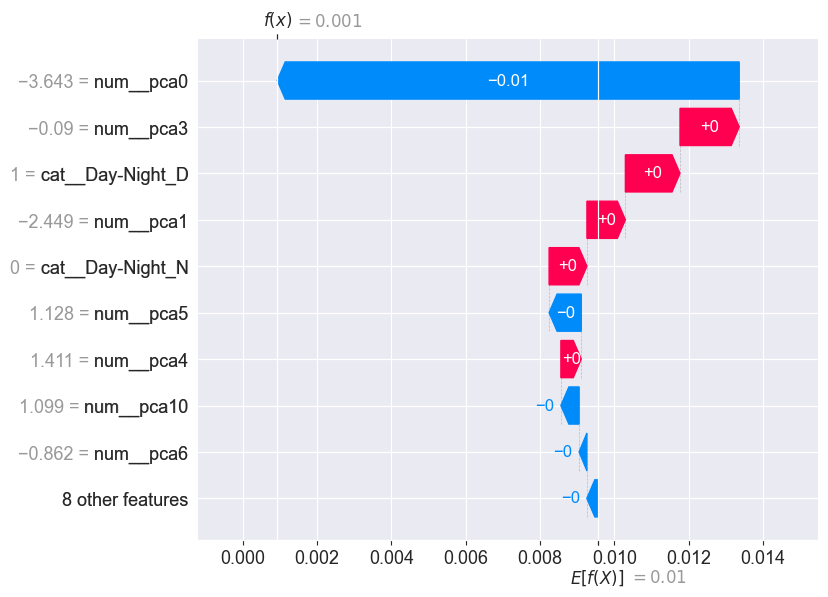

In [31]:
import numpy as np
import shap

prep = best_global_pipe.named_steps["prep"]
model = best_global_pipe.named_steps["model"]

# Biggest absolute error on full test
y_pred_test = np.clip(best_global_pipe.predict(X_test), 0, None)
abs_err = np.abs(y_test.values - y_pred_test)
idx_anom = int(np.argmax(abs_err))

print("Anom index:", idx_anom,
      "| y_true:", float(y_test.values[idx_anom]),
      "| y_pred:", float(y_pred_test[idx_anom]),
      "| abs_err:", float(abs_err[idx_anom]))

# Transform the single row
x_row = X_test.iloc[[idx_anom]]
x_row_trans = prep.transform(x_row)

# Feature names after preprocessing
try:
    feat_names_trans = prep.get_feature_names_out()
except Exception:
    feat_names_trans = [f"f{i}" for i in range(x_row_trans.shape[1])]

is_tree = model.__class__.__name__ in ["RandomForestRegressor", "GradientBoostingRegressor"]

try:
    if is_tree:
        explainer_local = shap.TreeExplainer(model)
        sv_row = explainer_local.shap_values(x_row_trans)
        base_value = explainer_local.expected_value

        exp = shap.Explanation(
            values=sv_row[0] if isinstance(sv_row, list) else sv_row[0],
            base_values=base_value if np.isscalar(base_value) else base_value[0],
            data=x_row_trans[0],
            feature_names=feat_names_trans
        )
        shap.plots.waterfall(exp)
    else:
        # Generic explainer: use a small background
        X_test_trans = prep.transform(X_test.iloc[:500])
        explainer_local = shap.Explainer(model, X_test_trans[:150])
        exp = explainer_local(x_row_trans)
        shap.plots.waterfall(exp[0])
except Exception as e:
    print("GLOBAL local SHAP failed:", repr(e))


4D) Local — SHAP for a plant-specific model

In [35]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# ----------------------------
# FAST LOCAL SHAP that works with mixed dtypes
# (encode categoricals -> SHAP, decode -> pipeline predict)
# ----------------------------
# assumes:
# pid, best_local_pipe fitted
# X_te_local (DataFrame), y_te_local (Series)

# 1) anomaly index
y_pred_local = np.clip(best_local_pipe.predict(X_te_local), 0, None)
abs_err_local = np.abs(y_te_local.values - y_pred_local)
idx_local_anom = int(np.argmax(abs_err_local))

print(f"[Plant {pid}] Anom idx: {idx_local_anom} | y_true: {float(y_te_local.values[idx_local_anom])} "
      f"| y_pred: {float(y_pred_local[idx_local_anom])} | abs_err: {float(abs_err_local[idx_local_anom])}")

# 2) speed knobs (lower = faster)
N_SUMMARY = 80     # 50–120
BG_N      = 25     # 15–40
MAX_EVALS = 200    # must be >= 2*num_features+1; 150–300 usually fine

rng = np.random.RandomState(11)
n_total = len(X_te_local)
summary_idx = rng.choice(n_total, size=min(N_SUMMARY, n_total), replace=False)
bg_idx      = rng.choice(n_total, size=min(BG_N, n_total), replace=False)

X_summary_df = X_te_local.iloc[summary_idx].copy()
X_bg_df      = X_te_local.iloc[bg_idx].copy()
x_row_df     = X_te_local.iloc[[idx_local_anom]].copy()

cols = list(X_te_local.columns)
cat_cols = X_te_local.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in cols if c not in cat_cols]

# Build category "vocab" per categorical column (use full test set to avoid missing codes)
cat_vocab = {}
for c in cat_cols:
    cat_vocab[c] = pd.Index(pd.Series(X_te_local[c].dropna().unique(), dtype="object"))

def encode_df(df: pd.DataFrame) -> np.ndarray:
    """Encode mixed-type DF -> purely numeric numpy array for SHAP."""
    out = np.zeros((len(df), len(cols)), dtype=float)
    for j, c in enumerate(cols):
        if c in cat_cols:
            # codes: -1 means NaN
            cat = pd.Categorical(df[c].astype("object"), categories=cat_vocab[c])
            out[:, j] = cat.codes.astype(float)
        else:
            out[:, j] = pd.to_numeric(df[c], errors="coerce").astype(float).to_numpy()
    return out

def decode_array(X: np.ndarray) -> pd.DataFrame:
    """Decode numeric array back to mixed-type DF for your pipeline."""
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)

    data = {}
    for j, c in enumerate(cols):
        col = X[:, j]
        if c in cat_cols:
            # round back to int codes (SHAP will only mix existing background values)
            codes = np.ri


[Plant 0] Anom idx: 136 | y_true: 0.01 | y_pred: 0.029370251699957512 | abs_err: 0.019370251699957514


In [33]:
import numpy as np
import shap

# ---------- assumes ----------
# pid, best_local_pipe fitted
# X_te_local, y_te_local exist

prep_local = best_local_pipe.named_steps["prep"]
model_local = best_local_pipe.named_steps["model"]

# Transform full local test set (may be sparse)
X_te_local_trans_full = prep_local.transform(X_te_local)

# Feature names after preprocessing
try:
    feat_names_local = prep_local.get_feature_names_out()
except Exception:
    feat_names_local = [f"f{i}" for i in range(X_te_local_trans_full.shape[1])]

# Biggest local error (on original scale)
y_pred_local = np.clip(best_local_pipe.predict(X_te_local), 0, None)
abs_err_local = np.abs(y_te_local.values - y_pred_local)
idx_local_anom = int(np.argmax(abs_err_local))

print(f"[Plant {pid}] Anom idx: {idx_local_anom} | y_true: {float(y_te_local.values[idx_local_anom])} "
      f"| y_pred: {float(y_pred_local[idx_local_anom])} | abs_err: {float(abs_err_local[idx_local_anom])}")

# ----------------------------
# SHAP summary on a subsample
# ----------------------------
n = min(600, X_te_local_trans_full.shape[0])
rng = np.random.RandomState(11)
sub_idx = rng.choice(X_te_local_trans_full.shape[0], size=n, replace=False)
X_sub = X_te_local_trans_full[sub_idx]

# If sparse, densify ONLY the subsample for SHAP (keeps memory safe)
try:
    from scipy import sparse
    if sparse.issparse(X_sub):
        X_sub = X_sub.toarray()
except Exception:
    pass

is_tree_l = model_local.__class__.__name__ in ["RandomForestRegressor", "GradientBoostingRegressor"]

if is_tree_l:
    explainer_l = shap.TreeExplainer(model_local)
    sv_l = explainer_l.shap_values(X_sub)

    shap.summary_plot(sv_l, X_sub, feature_names=feat_names_local, plot_type="bar", max_display=20)
    shap.summary_plot(sv_l, X_sub, feature_names=feat_names_local, max_display=20)

else:
    # ✅ FIX: use callable + background, force a compatible algorithm
    bg = X_sub[:min(150, len(X_sub))]

    explainer_l = shap.Explainer(
        model_local.predict,   # callable (works for KNN, Ridge, Lasso, etc.)
        bg,                    # background
        algorithm="permutation"
    )

    sv_l = explainer_l(X_sub)

    # For Explanation objects, use .values with summary_plot
    shap.summary_plot(sv_l.values, X_sub, feature_names=feat_names_local, plot_type="bar", max_display=20)
    shap.summary_plot(sv_l.values, X_sub, feature_names=feat_names_local, max_display=20)

# ----------------------------
# Waterfall for the anomaly point
# ----------------------------
x_row_local = X_te_local.iloc[[idx_local_anom]]
x_row_local_trans = prep_local.transform(x_row_local)

# If sparse, densify ONLY this row
try:
    from scipy import sparse
    if sparse.issparse(x_row_local_trans):
        x_row_local_trans = x_row_local_trans.toarray()
except Exception:
    pass

try:
    if is_tree_l:
        sv_row_l = explainer_l.shap_values(x_row_local_trans)
        base_value_l = explainer_l.expected_value

        exp_l = shap.Explanation(
            values=sv_row_l[0] if isinstance(sv_row_l, list) else sv_row_l[0],
            base_values=base_value_l if np.isscalar(base_value_l) else base_value_l[0],
            data=x_row_local_trans[0],
            feature_names=feat_names_local
        )
        shap.plots.waterfall(exp_l)

    else:
        exp_l = explainer_l(x_row_local_trans)
        shap.plots.waterfall(exp_l[0])

except Exception as e:
    print("LOCAL local SHAP failed:", repr(e))


[Plant 0] Anom idx: 136 | y_true: 0.01 | y_pred: 0.029370251699957512 | abs_err: 0.019370251699957514


PermutationExplainer explainer:  73%|███████▎  | 437/600 [15:00:04<5:40:23, 125.30s/it]   


KeyboardInterrupt: 

PART 5

In [36]:
# ============================================================
# Part 5 — Conclusion (CODING ONLY)
#  - Compare best GLOBAL ML vs Benchmark (RMSE + R2, train + test)
#  - Compare LOCAL strategy vs Benchmark (optional, if available)
#  - Print a compact "verdict" message
# ============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# -----------------------------
# 1) Best GLOBAL model vs Benchmark (from results_all)
# -----------------------------
# expects: results_all (includes 'Benchmark'), best_global_pipe, X_train, y_train, X_test, y_test, train_feat, test_feat
# expects: BENCH_COL, TARGET_COL
assert "results_all" in globals(), "results_all not found. Run Part 3 first."
assert "best_global_pipe" in globals(), "best_global_pipe not found. Run the tuning/XAI block first."
assert BENCH_COL in train_feat.columns and BENCH_COL in test_feat.columns, f"{BENCH_COL} missing from train_feat/test_feat."

# identify best non-benchmark row from results_all
best_global_name = results_all.loc[results_all["model"] != "Benchmark"].sort_values("rmse_test").iloc[0]["model"]

# predictions (global model)
yhat_tr = np.clip(best_global_pipe.predict(X_train), 0, None)
yhat_te = np.clip(best_global_pipe.predict(X_test), 0, None)

# benchmark predictions
ybench_tr = np.clip(train_feat[BENCH_COL].values, 0, None)
ybench_te = np.clip(test_feat[BENCH_COL].values, 0, None)

global_comp = pd.DataFrame({
    "metric": ["RMSE_train", "R2_train", "RMSE_test", "R2_test"],
    "Best_Global_Model": [
        rmse(y_train, yhat_tr),
        float(r2_score(y_train, yhat_tr)),
        rmse(y_test, yhat_te),
        float(r2_score(y_test, yhat_te)),
    ],
    "Benchmark": [
        rmse(y_train, ybench_tr),
        float(r2_score(y_train, ybench_tr)),
        rmse(y_test, ybench_te),
        float(r2_score(y_test, ybench_te)),
    ]
})

global_comp["Delta (Model - Bench)"] = global_comp["Best_Global_Model"] - global_comp["Benchmark"]
global_comp["% Improvement (RMSE)"] = np.where(
    global_comp["metric"].str.contains("RMSE"),
    100 * (global_comp["Benchmark"] - global_comp["Best_Global_Model"]) / global_comp["Benchmark"],
    np.nan
)

print(f"Best GLOBAL model (by test RMSE): {best_global_name}")
display(global_comp)

# verdict text (global)
rmse_imp = float(global_comp.loc[global_comp["metric"] == "RMSE_test", "% Improvement (RMSE)"].iloc[0])
r2_model = float(global_comp.loc[global_comp["metric"] == "R2_test", "Best_Global_Model"].iloc[0])
r2_bench = float(global_comp.loc[global_comp["metric"] == "R2_test", "Benchmark"].iloc[0])

if rmse_imp > 0:
    verdict_global = (
        f"VERDICT (GLOBAL): ML adds value vs Benchmark on TEST — "
        f"RMSE improves by {rmse_imp:.2f}% and R² improves by {(r2_model - r2_bench):.4f}."
    )
else:
    verdict_global = (
        f"VERDICT (GLOBAL): ML does NOT beat Benchmark on TEST — "
        f"RMSE change {rmse_imp:.2f}% and R² change {(r2_model - r2_bench):.4f}."
    )

print(verdict_global)

# -----------------------------
# 2) Optional: LOCAL strategy vs Benchmark (mean over best-per-plant)
# -----------------------------
# expects (if you ran local): best_local_per_plant, local_test_predictions, local_results_df, PLANT_COL
do_local = all(k in globals() for k in ["best_local_per_plant", "local_test_predictions"]) and ("Benchmark" in test_feat.columns)

if do_local:
    # compute per-plant benchmark RMSE/R2 + best-local RMSE/R2 on the PLANT test sets
    local_rows = []

    for pid in sorted(best_local_per_plant[PLANT_COL].unique()):
        best_label = best_local_per_plant.loc[best_local_per_plant[PLANT_COL] == pid, "model"].iloc[0]
        best_m = best_label.replace("Local-", "")
        key = (pid, best_m)

        if key not in local_test_predictions:
            continue

        pack = local_test_predictions[key]
        y_true = np.asarray(pack["y_true"])
        y_pred = np.asarray(pack["y_pred"])
        y_bench = pack.get("benchmark", None)

        if y_bench is None:
            continue

        y_bench = np.asarray(y_bench)

        local_rows.append({
            "Plant_ID": pid,
            "rmse_local": rmse(y_true, y_pred),
            "r2_local": float(r2_score(y_true, y_pred)),
            "rmse_bench": rmse(y_true, y_bench),
            "r2_bench": float(r2_score(y_true, y_bench)),
            "best_local_model": best_m
        })

    local_comp_df = pd.DataFrame(local_rows)

    if len(local_comp_df) > 0:
        local_summary = pd.Series({
            "RMSE_test_local_avg": float(local_comp_df["rmse_local"].mean()),
            "R2_test_local_avg": float(local_comp_df["r2_local"].mean()),
            "RMSE_test_bench_avg": float(local_comp_df["rmse_bench"].mean()),
            "R2_test_bench_avg": float(local_comp_df["r2_bench"].mean()),
        })

        local_rmse_imp = 100 * (local_summary["RMSE_test_bench_avg"] - local_summary["RMSE_test_local_avg"]) / local_summary["RMSE_test_bench_avg"]
        local_r2_delta = local_summary["R2_test_local_avg"] - local_summary["R2_test_bench_avg"]

        print("\nLOCAL strategy vs Benchmark (averaged across plants using each plant’s best local model):")
        display(local_summary.to_frame("value"))
        print(f"VERDICT (LOCAL): RMSE improvement = {local_rmse_imp:.2f}% | R² delta = {local_r2_delta:.4f}")

        # (optional) show which plants benefit most
        local_comp_df["rmse_improve_%"] = 100 * (local_comp_df["rmse_bench"] - local_comp_df["rmse_local"]) / local_comp_df["rmse_bench"]
        display(local_comp_df.sort_values("rmse_improve_%", ascending=False).head(10))
    else:
        print("\nLOCAL strategy comparison skipped: could not compute (missing benchmark vectors in local_test_predictions).")
else:
    print("\nLOCAL strategy comparison skipped (best_local_per_plant/local_test_predictions not found).")


Best GLOBAL model (by test RMSE): RandomForest


metric  Best_Global_Model  Benchmark  Delta (Model - Bench)  \
0  RMSE_train           0.000867   0.007659              -0.006792   
1    R2_train           0.996828   0.752354               0.244474   
2   RMSE_test           0.003567   0.007067              -0.003500   
3     R2_test           0.903834   0.622516               0.281318   

   % Improvement (RMSE)  
0             88.681724  
1                   NaN  
2             49.526688  
3                   NaN

VERDICT (GLOBAL): ML adds value vs Benchmark on TEST — RMSE improves by 49.53% and R² improves by 0.2813.

LOCAL strategy vs Benchmark (averaged across plants using each plant’s best local model):


value
RMSE_test_local_avg  0.003367
R2_test_local_avg    0.901755
RMSE_test_bench_avg  0.006664
R2_test_bench_avg    0.632353

VERDICT (LOCAL): RMSE improvement = 49.48% | R² delta = 0.2694


Plant_ID  rmse_local  r2_local  rmse_bench  r2_bench best_local_model  \
13        13    0.004240  0.919193    0.009634  0.582756     RandomForest   
9          9    0.004516  0.914739    0.010173  0.567400     RandomForest   
12        12    0.003762  0.915097    0.007983  0.617765              KNN   
11        11    0.004434  0.915383    0.009372  0.621871              KNN   
15        15    0.002472  0.915335    0.005179  0.628464              KNN   
10        10    0.004676  0.888040    0.009654  0.522769     RandomForest   
14        14    0.003819  0.896119    0.007603  0.588236              KNN   
3          3    0.004175  0.889688    0.008020  0.592892     RandomForest   
5          5    0.002779  0.910624    0.005324  0.672024              KNN   
6          6    0.002236  0.897702    0.004238  0.632407              KNN   

    rmse_improve_%  
13       55.992145  
9        55.605197  
12       52.870200  
11       52.694934  
15       52.263255  
10       51.564189  
14       49.772324  
3        47.945818  
5        47.797863  
6        47.246754